# __Homework 2 - Instagram Profiles & Posts__

In [72]:
%pip install pyarrow
%pip install datatable

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [272]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import datatable as dt # probably needed !pip install datatable
import re
import os
import statistics
import subprocess
from math import pi, floor, log10, ceil
from scipy.stats import pearsonr, f_oneway
from functions import Dataset, get_types, optimize_cols, downcast_int, line_count, cool_ticks, clock_graph, EMOJIS, safe_detect


SAMPLE_SIZE = 10000

%matplotlib inline
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4
sns.set_theme(style='darkgrid', palette='pastel')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

***

### __Preprocessing__

We create a `Dataset` class that will help us manage the 3 datasets throughout the processing. As the datasets are very big, we settled to load only some columns for each question. This is managed by the 
```python
Dataset.col(columns:list) -> pd.DataFrame
``` 
method that will be used multiple times throughout the homework to selectively load only some columns from the csv files, using `datatable` library as it is more efficient in the usage of multiple cores, and loads way faster. Then the `datatable` object is casted to a common `pandas` DataFrame.

In [74]:
datasets = [
    Dataset(file='instagram-dataset/instagram_profiles.csv'), 
    Dataset(file='instagram-dataset/instagram_locations.csv'), 
    Dataset(file='instagram-dataset/instagram_posts.csv')
]
profiles, locations, posts = datasets

We inferred most of the types of the columns from the descriptions [here](https://www.kaggle.com/datasets/shmalex/instagram-dataset/versions/3), at least for what regard whether they are numeric, `boolean`, string type or something else.
We want to optimize the `dtype` of each column since in this way we'll save some precious memory space, and overall ease the computation.

For **numeric** and **string** dtypes:
- if they can assume only a small number of values we cast the to `categorical`, which is a special `dtype` that represents categorical data. This was applied to columns: 
    - 'post_type': [1,2,3]
    - 'cd' : country names (around 200 values)
    
For **numeric** dtypes:
- if they're integer we temporarily assign them to `Int64`, but further optimization will be performed later
- else they're assigned as `float`
    - 'lat' and 'lng' are assigned directly as `Float32` since the values they contain are in a fairly small range with not much precision needed

For **string** dtypes:
- if they represent dates they will be casted to `datetime64[ns,]` in the `Datetime.col()` method
    - 'cts'
- they are assigned as `pd.StringDtype(storage='pyarrow')` as we noted that this (experimental) dtype allows us to highly improve memory usage
    - this is appllied to the majority of columns

In [75]:
profiles.types = {
#     'sid' : 'Int64',
    'profile_id' : 'Int64',
    'profile_name' : pd.StringDtype(storage='pyarrow'),
    'firstname_lastname' : pd.StringDtype(storage='pyarrow'),
    'description' : pd.StringDtype(storage='pyarrow'),
    'following' : 'Int64',
    'followers' : 'Int64',
    'n_posts' : 'Int64',
    'url' : pd.StringDtype(storage='pyarrow'),
#     'cts' : pd.DatetimeTZDtype(tz='UTC'), #obtained through parse_dates=['cts']
    'is_business_account' : pd.BooleanDtype()
}
posts.types = {
#     'sid' : 'Int64', # gives an error, maybe because it's the index?
    'sid_profile' : 'Int64',
    'post_id' : pd.StringDtype(storage='pyarrow'),
    'profile_id' : 'Int64',
    'location_id' : 'Int64',
    'description' : pd.StringDtype(storage='pyarrow'),
    'post_type' : pd.CategoricalDtype(categories=[1,2,3]),
    'numbr_likes' : 'Int64',
    'number_comments' : 'Int64'
}
locations.types = {
#     'sid' : 'Int64', # gives an error, maybe because it's the index?
    'id' : 'Int64',
    'name' : pd.StringDtype(storage='pyarrow'),
    'street' : pd.StringDtype(storage='pyarrow'),
    'zip' : pd.StringDtype(storage='pyarrow'),
    'city' : pd.StringDtype(storage='pyarrow'),
    'region' : pd.StringDtype(storage='pyarrow'),
    'cd' : pd.CategoricalDtype(),
    'phone' : pd.StringDtype(storage='pyarrow'),
    'aj_exact_city_match' : pd.BooleanDtype(),
    'aj_exact_country_match' : pd.BooleanDtype(),
    'blurb' : pd.StringDtype(storage='pyarrow'),
    'dir_city_id' : pd.StringDtype(storage='pyarrow'),
    'dir_city_name' : pd.StringDtype(storage='pyarrow'),
    'dir_city_slug' : pd.StringDtype(storage='pyarrow'),
    'dir_country_id' : pd.CategoricalDtype(),
    'dir_country_name' : pd.CategoricalDtype(),
    'lat' : pd.Float32Dtype(),
    'lng' : pd.Float32Dtype(),
    'primary_alias_on_fb' : pd.StringDtype(storage='pyarrow'),
    'slug' : pd.StringDtype(storage='pyarrow'),
    'website' : pd.StringDtype(storage='pyarrow'),
}

Since the `int` columns are the most used in the research questions, we try to _squeeze_ out each and every useful Byte. As such we perform a further optimization on their dtypes, trying to downcast their `int` dtype to the minimum.

    Int8 < Int16 < Int32 < Int64 
    
As such we wrote some functions that for each `Int64` column previously assigned, reads the values of that column and then returns the smallest possible `IntXX` dtype.

---
At the end we obtain a substantial reduction of memory usage, **saving around 60 to 70%** from the unoptimized version (note that we estimated this in a sample of the whole dataset)

In [76]:
for ds in datasets:
    if not ds.load_types():
        int_cols = [k for k,v in ds.types.items() if v == 'Int64']
        print(int_cols)
        ds.types.update(optimize_cols(ds.file_name, int_cols, delimiter='\t'))
        print(f'Optimized {len(int_cols)} types for {ds.name()}')
    ds.save_types()

for ds in datasets:
    ds.df = pd.read_csv(ds.file_name, dtype=ds.types, index_col='sid', delimiter='\t', parse_dates=['cts'], nrows=SAMPLE_SIZE)
    avg_mem_unoptimized = pd.read_csv(ds.file_name, index_col='sid', delimiter='\t', nrows=SAMPLE_SIZE).memory_usage(deep=True).sum()/SAMPLE_SIZE
    avg_mem_optimized = ds.df.memory_usage(deep=True).sum()/SAMPLE_SIZE
    print(f'{ds.name().ljust(19)} mean optimized memory usage per entry:  {round(avg_mem_optimized):3} B vs {round(avg_mem_unoptimized):4} B  : {round(avg_mem_optimized/avg_mem_unoptimized*100,2):5}%') 

instagram_profiles  mean optimized memory usage per entry:  150 B vs  542 B  : 27.71%
instagram_locations mean optimized memory usage per entry:  272 B vs 1117 B  : 24.34%
instagram_posts     mean optimized memory usage per entry:  314 B vs  748 B  : 42.05%


In [77]:
for ds in datasets:
    print(ds.name())
    {print(f"\t{k:25}\t{v}") for k,v in ds.types.items() if pd.api.types.is_numeric_dtype(v)}

instagram_profiles
	profile_id               	UInt64
	following                	UInt32
	followers                	UInt32
	n_posts                  	UInt32
	is_business_account      	boolean
instagram_locations
	id                       	UInt64
	aj_exact_city_match      	boolean
	aj_exact_country_match   	boolean
	lat                      	Float32
	lng                      	Float32
instagram_posts
	sid_profile              	Int32
	profile_id               	UInt64
	location_id              	UInt64
	numbr_likes              	Int64
	number_comments          	UInt32


***

### __1. [RQ1] After collecting information, the Data Scientists have to know what dataset they are dealing with, so let's start with an Exploratory Data Analysis (EDA). What can you say about our datasets? Please summarise its main characteristics with visual and tabular methods.__

***

As a first step it is useful to visualize the datasets with which we will have to work through tables, in this way we discover the variables present (the columns), we understand their content through a brief description and we display the type with which they were loaded

#### Profiles 
| Field | Description | Type |
|---|---|---|
| SID | Sequence ID | `int` |
| profile_id | Instagrams ID | `int `|
| profile_name | profile name | `string` |
| firstname_lastname | firstname lastname | `string` |
| description | May contain '\n' | `string` |
| following | Number of following profile at the moment it was visited | `int` |
| followers | Number of followers at the moment it was visited | `int` |
| n_posts | Number of posts at the moment it was visited | `int` |
| url | Url in profile description | `string` |
| cts | Timestamp when the profile was visited | `datetime` |
| is_business_account | Boolean flag if that profile was makred by the owner as business account | `bool` |

#### Locations

| Field | Description | Type |
|---|---|---|
| SID | Sequence ID | `int` |
| ID | Instagrams ID | `int` |
| Name | Locations Name | `string` |
| Street | Street Address, may contain '\n' | `string` |
| ZIP | Zip code | `string` |
| City | City Name | `string` |
| Region | Region | `string` |
| CD | Country Code | `string` |
| Phone | The phone in format as on the Instragram | `string` |
| aj_exact_city_match | The Instagrams Internal key | `bool` |
| aj_exact_country_match | The Instagrams Internal key | `bool` |
| blurb | Description of the place, may contain '\n' | `string` |
| dir_city_id | The Instagrams internal City ID | `string` |
| dir_city_name | city Name | `string` |
| dir_city_slug | City tag (sortof) | `string` |
| dir_country_id | Country ID | `categorical` |
| dir_country_name | country | `categorical` |
| lat | Latitude | `float` |
| lng | Longtitude | `float` |
| primary_alias_on_fb | Bool Flag | `bool` |
| slug | ??? | `string` |
| website | The URL to web site, may contain more then 1 URL, may contain '\n' | `string` |
| cts | Timestamp when the location was visited | `datetime` |

#### Posts
| Field | Description | Type |
|---|---|---|
| SID | Sequence ID | `int` |
| sid_profile | Sequence ID of the profile from *Profiles* table, -1 if not in *Profiles* table | `int` |
| post_id | Instagrams ID | `string` |
| profile_id | Instagrams ID may be null | `int` |
| location_id | Instagrams ID | `int` |
| cts | Timestamp when the Post was created | `datetime` |
| post_type | 1 - Photo, 2 - Video, 3 - multy | `categorical` |
| description | May contain '\n' | `string` |
| number_likes | Number of Likes at the moment it was visited | `int` |
| number_comments | Number of comments at the moment it was visited | `int` |

After acquiring the information on the columns it is also interesting to know the number of rows present in the dataset, for this purpose, we will only import the sid column for each of the dataset and check their length.

In [78]:
for ds in datasets:
    print(f'{ds.name():20} {len(ds):11} rows')

instagram_profiles       4509586 rows
instagram_locations      1022658 rows
instagram_posts           100000 rows


It is clear that posts dataset is pretty big with almost 43 milions rows.

Having now information about rows and columns, let's carry out simple operations only on a small subset (in terms of rows) of each of them. We decide to proceed in this way because the analysis of the entire dataset would be too expensive computationally and for the purpose of this EDA we do not need accurate results but we simply want to have an idea of what we will be working with in the actual analysis.

Let's first visualize the first 5 rows of each dataset, in this way we see concretely examples of what each cell can contain

First 5 rows of locations dataset:

In [79]:
locations.df.head()

,id,name,street,zip,city,region,cd,phone,aj_exact_city_match,aj_exact_country_match,...,dir_city_name,dir_city_slug,dir_country_id,dir_country_name,lat,lng,primary_alias_on_fb,slug,website,cts
sid,,,,,,,,,,,,,,,,,,,,,
719981,110296492939207,"Playa de Daimuz - Valencia, España",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,...,<NA>,<NA>,NaN,NaN,-0.139475,38.974392,daimuzplaya,playa-de-daimuz-valencia-espana,https://es.wikipedia.org/wiki/Daimuz,2019-05-29 01:21:29.987
719983,274391278,Nová Vieska,<NA>,<NA>,Nová Vieska,<NA>,SK,<NA>,True,False,...,Kis-Újfalu,kis-ujfalu,SK,Slovakia,18.466667,47.866669,<NA>,nova-vieska,<NA>,2019-05-29 01:21:38.037
719985,148885595789195,Everest Today,Himalayas,+977,"Kathmandu, Nepal",<NA>,NP,<NA>,False,False,...,Pasupati,pasupati,NP,Nepal,85.330147,27.70196,EverestToday,everest-today,<NA>,2019-05-29 01:21:46.295
719987,263258277,BULAC - Bibliothèque universitaire des langues...,"65, rue des Grands-Moulins",75013,"Paris, France",<NA>,FR,01 81 69 18 00,False,False,...,13ème Arrondissement Paris,13eme-arrondissement-paris,FR,France,2.375995,48.82724,BULAC.Paris,bulac-bibliotheque-universitaire-des-langues-e...,www.bulac.fr,2019-05-29 01:21:54.355
326443,406147529857708,ABC Cable Networks Group,3800 W Alameda Ave,91505,"Burbank, California",<NA>,US,(818) 569-7500,False,False,...,<NA>,<NA>,NaN,NaN,-118.341866,34.153267,<NA>,abc-cable-networks-group,<NA>,2019-04-02 15:22:55.703


First 5 rows of posts dataset:

In [80]:
posts.df.head()

,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
sid,,,,,,,,,
28370919,3496776,BXdjjUlgcgq,2237947779,1022366247837915,2017-08-06 20:06:57,2,Wreckloose! Deevalley bike park laps on the @i...,80,0
28370932,-1,BVg0pbolYBC,5579335020,457426771112991,2017-06-19 09:31:16,1,🙌🏼 believe in ya dreams 🙌🏼 just like I believe...,25,1
28370933,-1,BRgkjcXFp3Q,313429634,457426771112991,2017-03-11 20:05:03,1,#meraviglia #incensi #the #candele #profumo #a...,9,0
28370934,-1,BKTKeNhjEA7,1837592700,457426771112991,2016-09-13 16:27:16,1,#teatime #scorpion #friends #love #mountains #...,4,0
28370935,-1,8-NQrvoYLX,1131527143,457426771112991,2015-10-18 10:19:27,1,thE sky gavE mE a #constEllation,8,0


First 5 rows of profiles dataset:

In [81]:
profiles.df.head()

,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
sid,,,,,,,,,,
4184446,4721049632,jphillip033,John Pierce,"""Document Everything Always""",250,146,170,<NA>,2019-08-01 14:38:55.394000-04:00,False
4184457,590583002,mama_haas,Deanna,Trying to enjoy the simple things in life. Kni...,534,1145,2878,www.etsy.com/shop/MamaHaas69,2019-08-01 14:39:36.526000-04:00,False
4184460,1074146658,yellowlightbreen,Eliza Gray,Maine is for Lovers,469,324,431,elizajanegray.com,2019-08-01 14:39:54.407000-04:00,False
4184461,1472038842,tec1025,Thomas Clark,<NA>,<NA>,<NA>,<NA>,<NA>,2019-08-01 14:40:06.472000-04:00,<NA>
4184462,3531420803,luckyfluff,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2019-08-01 14:40:07.806000-04:00,<NA>


As a second step we display basic info of the dataset we are working on, number of rows chosen, which rows have been chosen, the number of non-null values for each variable and the type of each variable and also the total memory usage.

Info of locations dataset:

In [82]:
locations.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 719981 to 729103
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      10000 non-null  UInt64        
 1   name                    10000 non-null  string        
 2   street                  6859 non-null   string        
 3   zip                     6690 non-null   string        
 4   city                    9057 non-null   string        
 5   region                  5 non-null      string        
 6   cd                      9062 non-null   string        
 7   phone                   5664 non-null   string        
 8   aj_exact_city_match     9749 non-null   boolean       
 9   aj_exact_country_match  9749 non-null   boolean       
 10  blurb                   3793 non-null   string        
 11  dir_city_id             4767 non-null   string        
 12  dir_city_name           4767 non-null   

Info of posts dataset:

In [83]:
posts.df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 28370919 to #bw #blackandwhite #bwphoto #monochrome
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   sid_profile      9485 non-null   Int32         
 1   post_id          9485 non-null   string        
 2   profile_id       9482 non-null   UInt64        
 3   location_id      9482 non-null   UInt64        
 4   cts              9482 non-null   datetime64[ns]
 5   post_type        9482 non-null   category      
 6   description      8784 non-null   string        
 7   numbr_likes      8972 non-null   Int64         
 8   number_comments  8972 non-null   UInt32        
dtypes: Int32(1), Int64(1), UInt32(1), UInt64(2), category(1), datetime64[ns](1), string(2)
memory usage: 2.4+ MB


Info of profiles dataset:

In [84]:
profiles.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 4184446 to 4195503
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype                                 
---  ------               --------------  -----                                 
 0   profile_id           10000 non-null  UInt64                                
 1   profile_name         10000 non-null  string                                
 2   firstname_lastname   9571 non-null   string                                
 3   description          5096 non-null   string                                
 4   following            6379 non-null   UInt32                                
 5   followers            6379 non-null   UInt32                                
 6   n_posts              6379 non-null   UInt32                                
 7   url                  2325 non-null   string                                
 8   cts                  9999 non-null   datetime64[ns, pytz.FixedOffset

Through the describe function we can instead quickly calculate some interesting statistics, we have maximum, minimum, quartiles, mean and standard deviation. Very useful information to get an idea of the distribution of the variables for which we calculate them.

For the posts dataset we apply the describe method to the number of likes and number of comments columns:

In [85]:
posts.df[["numbr_likes", "number_comments"]].describe()

,numbr_likes,number_comments
count,8972.000000,8972.000000
mean,339.562862,7.768725
std,4316.838770,150.068287
min,0.000000,0.000000
25%,20.000000,0.000000
50%,48.500000,1.500000
75%,126.000000,5.000000
max,298913.000000,13983.000000


For the profiles dataset we apply the describe method to the number of following, followers and posts columns:

In [86]:
profiles.df[["following", "followers", "n_posts"]].describe()

,following,followers,n_posts
count,6379.000000,6.379000e+03,6379.000000
mean,805.535037,6.636363e+03,579.079636
std,1057.607105,6.963743e+04,1049.373491
min,0.000000,0.000000e+00,0.000000
25%,226.000000,2.730000e+02,89.000000
50%,498.000000,6.710000e+02,251.000000
75%,948.500000,1.490000e+03,662.000000
max,7505.000000,2.793338e+06,37753.000000


An important information to know when analyzing a dataset is the number of missing values for each variables. We already found the numbers of "Non null" but let's now visualize, trough a barplot for each dataset, which are the proportions of "NA".

To keep in mind that these are only approximations of the true percentages since we are not working on the complete datasets

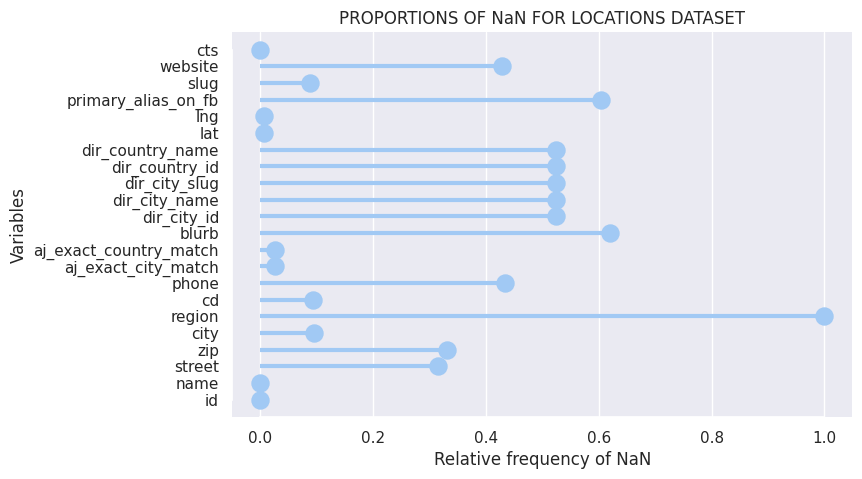

In [275]:
# plt.rcParams['figure.figsize'] = [8,6]
values_loc = np.array(locations.df.isna().sum())/len(locations.df)
my_range_loc =range(0,len(values_loc))
names_loc = locations.df.columns.values.tolist()
plt.grid(axis='y')
plt.hlines(y=names_loc, xmin=0, xmax=values_loc, linewidth=3, color='b')
plt.scatter(values_loc, my_range_loc, s=150, alpha=1, color='b')
plt.title("PROPORTIONS OF NaN FOR LOCATIONS DATASET")
plt.xlabel("Relative frequency of NaN")
plt.ylabel("Variables")
sns.despine(trim=True)
plt.show()

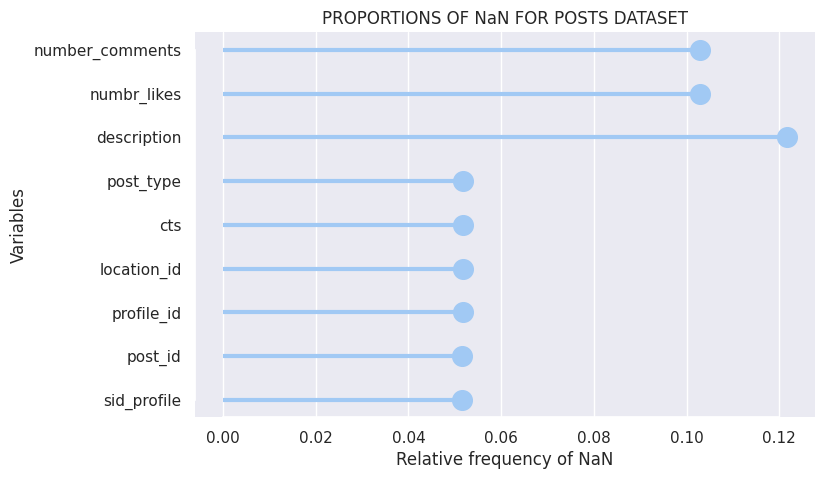

In [277]:
values_posts = np.array(posts.df.isna().sum())/len(posts.df)
my_range_posts =range(0,len(values_posts))
names_posts = posts.df.columns.values.tolist()
plt.grid(axis='y')
plt.hlines(y=names_posts, xmin=0, xmax=values_posts, linewidth=3, color='b')
plt.scatter(values_posts, my_range_posts, s=200, color='b')
plt.title("PROPORTIONS OF NaN FOR POSTS DATASET")
plt.xlabel("Relative frequency of NaN")
sns.despine(trim=True)
plt.ylabel("Variables")
plt.show()

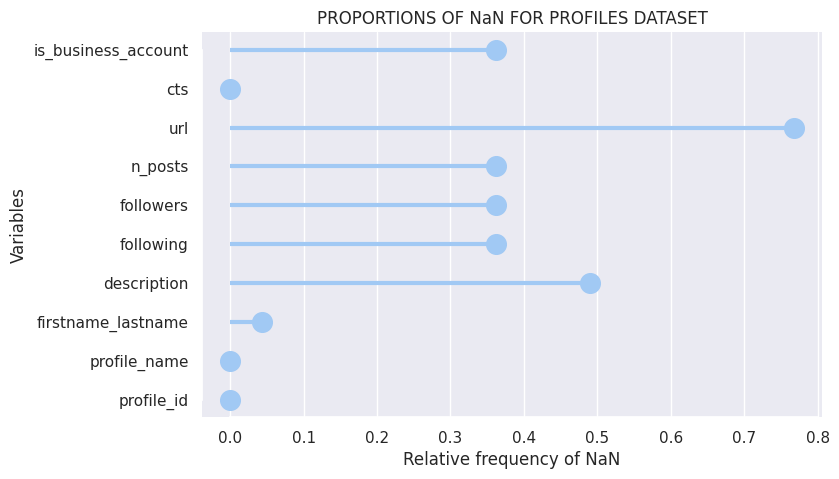

In [281]:
values_prof = np.array(profiles.df.isna().sum())/len(profiles.df)
my_range_prof =range(0,len(values_prof))
names_prof = profiles.df.columns.values.tolist()
plt.grid(axis='y')
plt.hlines(y=names_prof, xmin=0, xmax=values_prof, linewidth=3, color='b')
plt.scatter(values_prof, my_range_prof, s=200, color='b')
plt.title("PROPORTIONS OF NaN FOR PROFILES DATASET")
plt.xlabel("Relative frequency of NaN")
plt.ylabel("Variables")
sns.despine(trim=True)
plt.show()

***

### __2. [RQ2] Let's explore the dataset by finding simple insights regarding the profile and posts.__

***

#### Plot the number of posts for each profile in descending order.

In [99]:
#To create a subset with only the interested columns
d_prof = profiles.col(["profile_name", "n_posts", "following", "followers", "is_business_account"])

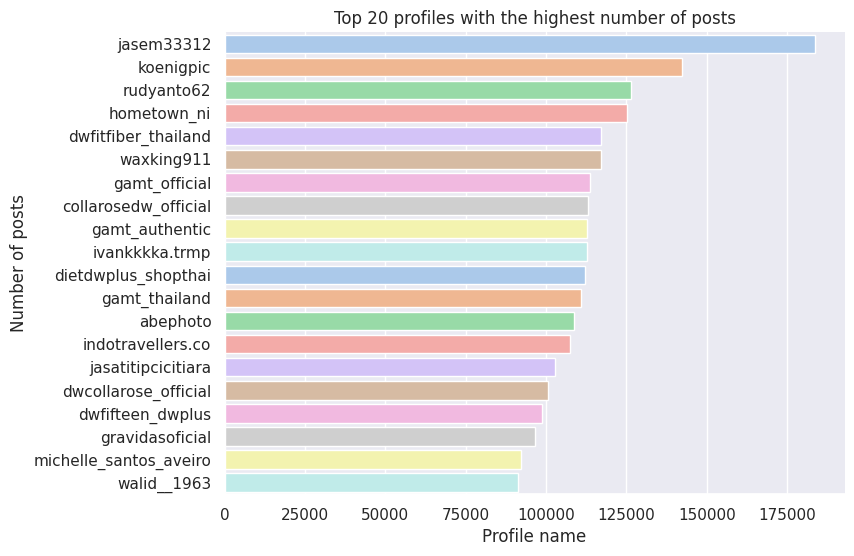

In [284]:
#To limit it to the top 20
plt.rcParams['figure.figsize'] = [8,6]
plot_order = d_prof.sort_values(by=['n_posts'], ascending=False).head(20)
sns.barplot(data=plot_order, x="n_posts", y="profile_name", palette="pastel", orient='h').set(title='Top 20 profiles with the highest number of posts')
sns.despine()
plt.xlabel("Profile name")
#plt.xticks(rotation=90)
plt.ylabel("Number of posts")
plt.show()

####  What posts have the highest number of "likes"?

In [103]:
#We create a subset with only the interested columns
d_posts = posts.col(["profile_id", "location_id", "post_type", "numbr_likes", "number_comments", "post_id"], index=False)

In [104]:
#To print the top 20 most liked posts
pop_posts = d_posts.nlargest(20, ['numbr_likes'])
pop_posts

,post_id,profile_id,location_id,post_type,numbr_likes,number_comments
85047,BZ_YhYugj_s,191110424,256808124805616,1,852230,1491
30773,BwMpiRqgGKk,293427480,1012959430,1,655354,6482
74739,BmOlqNbA98p,522601519,238970550099065,1,586484,6444
14566,Bb90GKnHlH5,12017431,115139952,1,472921,4235
41546,BsShUuXDDHh,23299911,4523118,1,352795,3318
1861,BWatkdZACtC,7061024,59743640,1,298913,386
49316,BeIrW70DHg1,787132,271576538,1,273971,585
90937,BQc65i1BLYh,22288455,265805924,1,265909,937
35787,BDlWL0ALf5W,28902942,255558274,1,243842,1087
18750,BwRWzebnL9u,256358723,499723383824358,1,243354,2367


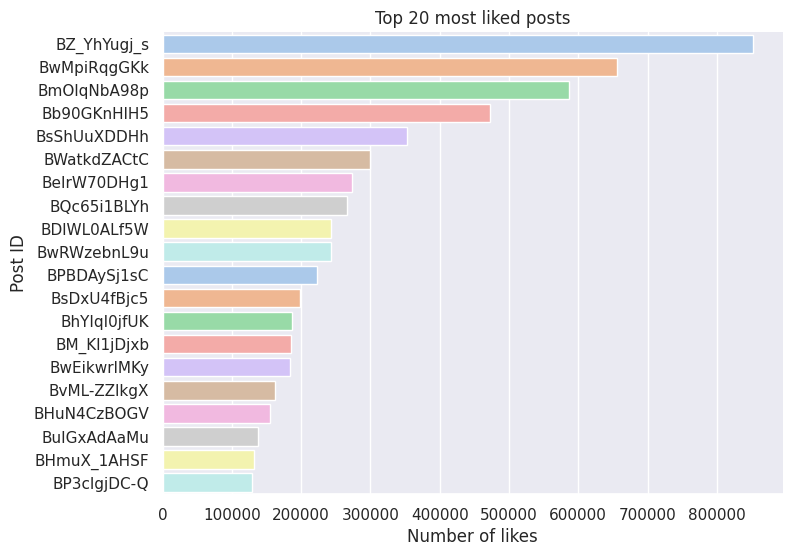

In [285]:
#Plot
plt.rcParams['figure.figsize'] = [8,6]
sns.barplot(data=pop_posts, x="numbr_likes", y="post_id", palette="pastel", orient='h').set(title='Top 20 most liked posts')
sns.despine()
plt.ylabel("Post ID")
plt.xlabel("Number of likes")
plt.show()

####  What posts have the most and the least number of comments?

In [106]:
#To print the top 10 posts with the most number of comments
most_num_comm = d_posts.nlargest(10, ['number_comments'])
most_num_comm

,post_id,profile_id,location_id,post_type,numbr_likes,number_comments
50077,BuvfTmgFsuY,3950062135,1035366326511834,1,3867,31655
5633,BgkKMt4hAW7,2955286544,1012854533,1,302,13983
30773,BwMpiRqgGKk,293427480,1012959430,1,655354,6482
74739,BmOlqNbA98p,522601519,238970550099065,1,586484,6444
52459,BuIGxAdAaMu,8124614,1022336243,2,137175,5262
14295,1IqH8bsCFI,268353079,250507028,2,85797,5246
14566,Bb90GKnHlH5,12017431,115139952,1,472921,4235
40130,Bx_Iw7PpxNE,188523455,1681667078572214,1,3136,4051
41546,BsShUuXDDHh,23299911,4523118,1,352795,3318
41656,Bo9qDpSHIrR,249063683,142762489677115,1,1483,3272


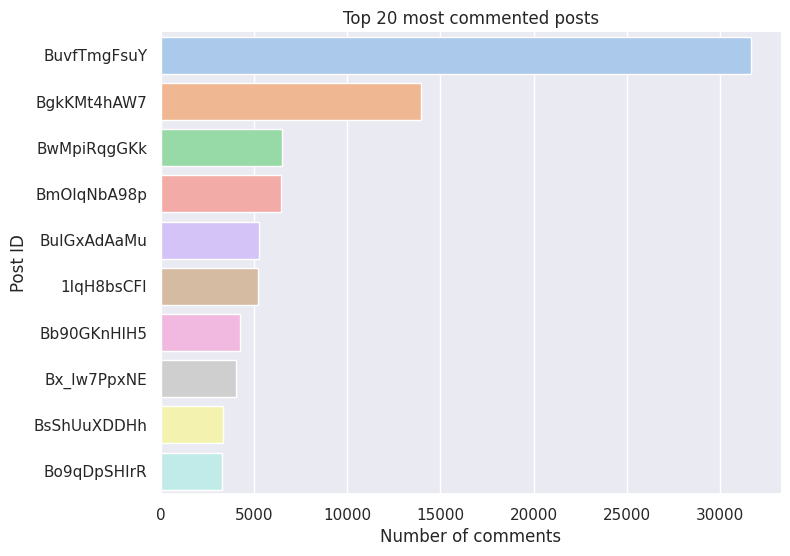

In [286]:
#Plot
plt.rcParams['figure.figsize'] = [8,6]
sns.barplot(data=most_num_comm, x="number_comments", y="post_id", palette="pastel", orient='h').set(title='Top 20 most commented posts')
# plt.xticks(rotation=90)
sns.despine()
plt.xlabel("Number of comments")
plt.ylabel("Post ID")
plt.show()

This is the post with the most number of comments in our dataset:

In [108]:
most_num_comm.head(1)

,post_id,profile_id,location_id,post_type,numbr_likes,number_comments
50077,BuvfTmgFsuY,3950062135,1035366326511834,1,3867,31655


In [100]:
#To print the last 10 posts with the least number of comments
least_num_comm = d_posts.dropna(subset='number_comments').nsmallest(10, ['number_comments'])
least_num_comm

,post_id,profile_id,location_id,post_type,numbr_likes,number_comments
0,BXdjjUlgcgq,2237947779,1022366247837915,2,80,0
2,BRgkjcXFp3Q,313429634,457426771112991,1,9,0
3,BKTKeNhjEA7,1837592700,457426771112991,1,4,0
4,8-NQrvoYLX,1131527143,457426771112991,1,8,0
11,Bx-ptmpinBs,42762751,282618748,1,16,0
12,Bx9uKZAAHDg,198737807,282618748,1,9,0
13,Bx5qGE0AlMM,4319359707,282618748,1,9,0
23,Bxf-Vl4lK2S,290686219,4267235,1,20,0
24,BxCrxafBm-9,8621190715,282618748,1,2,0
28,BwRE4lYhQ3r,12722209053,130379727582083,1,3,0


This is the post with the least number of comments in our dataset, but as we can see, there are other posts with 0 comments.

In [75]:
least_num_comm.tail(1)

,post_id,profile_id,location_id,post_type,numbr_likes,number_comments
0,BXdjjUlgcgq,2237947779,1022366247837915,2,80,0


####  How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results.

In [142]:
#To count just the N/A (so the posts with no tagged location)
nan_loc = d_posts["location_id"].isna().sum()
loc_tag = d_posts.shape[0] - nan_loc
data = [nan_loc,loc_tag]
data

[0, 100000]

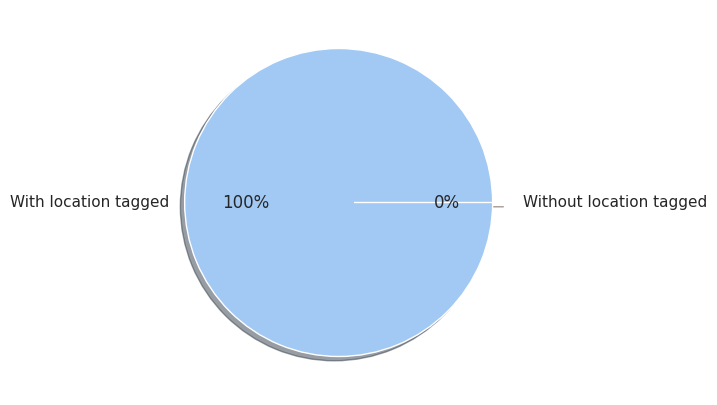

In [143]:
#Plot
plt.figure(1, figsize=(25, 5))
colors = sns.color_palette('pastel')[0:3]
data = [loc_tag, nan_loc]
explode = (0.1, 0)

labels=['With location tagged', 'Without location tagged']
plt.pie(data, explode=explode, labels=labels, colors=colors, autopct='%.0f%%', shadow=True)

plt.show()

The posts with a tagged location are the majority in our dataset.
TODO : smth more?

####  How many posts include only photos? How many also have videos?

In [113]:
#To count how many posts are included in the three different types
post_type = d_posts["post_type"].value_counts() 
post_type

1    94171
2     5829
3        0
Name: post_type, dtype: int64

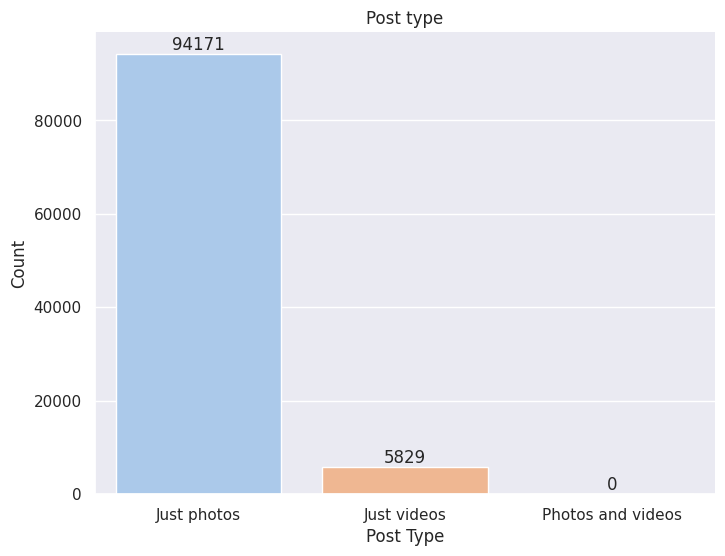

In [287]:
#Plot
g = sns.countplot(x=d_posts["post_type"], palette = "pastel", orient='h')
g.bar_label(g.containers[0], label_type='edge')
g.set(title='Post type')
plt.xlabel("Post Type")
plt.ylabel("Count")
plt.xticks([0, 1, 2], ['Just photos', 'Just videos', 'Photos and videos'])
sns.despine()
plt.show()

####  What's the percentage of business accounts vs non- business? What can you interpret regarding that percentage?

In [92]:
#To count the values including the N/A
b_prof = d_prof["is_business_account"].value_counts(dropna=False)
b_prof

False    2590069
<NA>     1064263
True      855254
Name: is_business_account, dtype: Int64

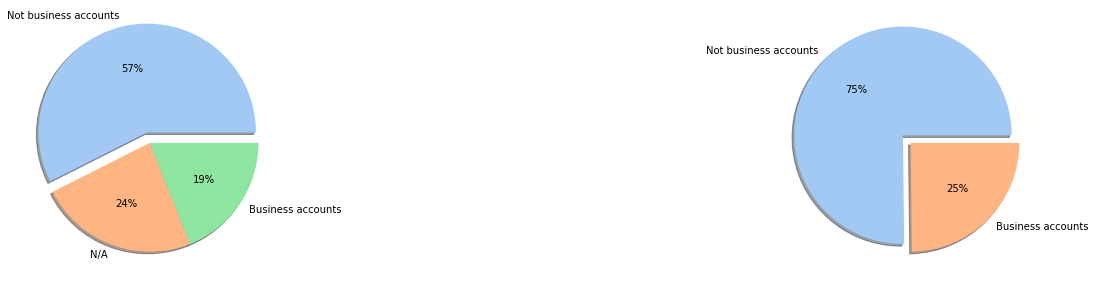

In [93]:
#Plots
plt.figure(1, figsize=(25, 5))
colors = sns.color_palette('pastel')[0:4]
explode1 = (0.1, 0)
explode2 = (0.1, 0, 0)
 
plt.subplot(1, 2, 1)
labels=['Not business accounts', 'N/A', 'Business accounts']
plt.pie(b_prof, explode=explode2, labels=labels, colors=colors, autopct='%.0f%%', shadow=True)


plt.subplot(1, 2, 2)
labels=['Not business accounts', 'Business accounts']
plt.pie(b_prof[b_prof.index!='<NA>'], explode=explode1, labels=labels, colors=colors, autopct='%.0f%%', shadow=True)

plt.show()

Most of the profiles are not business accounts, maybe beacause this kind of account is mostly used by influencers or companies, which are a small percentage in the totality of Instagram accounts.
TODO : more?

In [94]:
del d_prof, d_posts

***

### 3. __[RQ3] Now it's important to understand the most common times in which users publish their posts__

***

#### What is the most common time in which users publish their posts?

I can visualize the most common time by using a radar chart. We observe that the peak hour for posting is at 19, and in general in the evening.

In [289]:
time = posts.col(['cts'], index=False)
time['hour'] = time['cts'].dt.hour

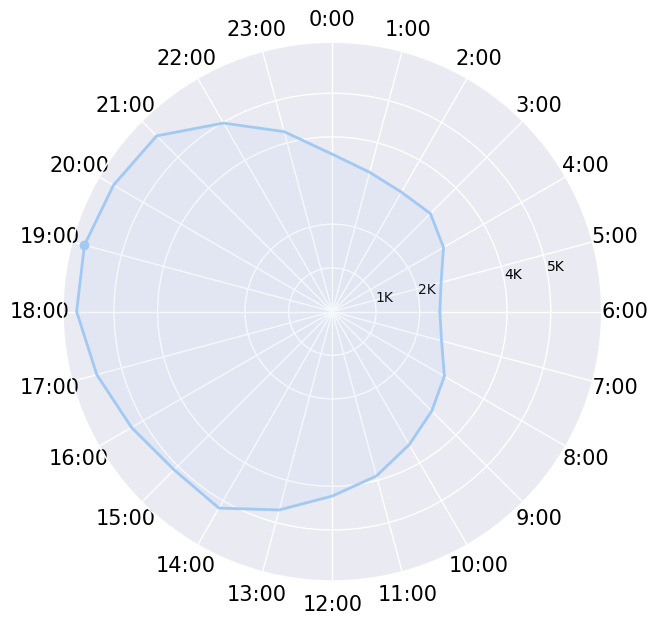

In [290]:
hours = time.hour.value_counts(sort=False).sort_index().to_frame()

clock_graph(hours.hour)

####  Create a function that receives a time intervals list as a parameter and returns a plot with the number of posts for each given interval.

In [291]:
def inter(h,intervals:list):
    """Assigns each hour to an interval"""
    assert min(intervals)>0 and max(intervals)<=24, 'Values must be included in 1..24'
    intervals = { f"[{intervals[i-1]}:00,{intervals[i]-1}:59]" : (intervals[i-1],intervals[i]-1) for i in range(len(intervals)) }
    
    for k,(m,M) in intervals.items():
        if (h >= m and h <= M) or (m>M and (h >= m or h <= M)):
            return k
    assert False, 'Interval not given: ' + str(h)
        
def plot_intervals(hours_count, inters=range(0,24,4), col_name='hour', plot=True):
    """A radarplot with the hours divided into intervals
    :hours_count: a dataframe where index is the hours
    :inters: a sorted list of hours breakpoints, with values between 1 and 24 
    :col_name: the column of which the values have to be plotted
    """
    intervals = { f"[{inters[i-1]}:00,{inters[i]-1}:59]" : (inters[i-1],inters[i]-1) for i in range(len(inters)) }
    I = pd.CategoricalDtype(categories=intervals.keys() , ordered=True)

    hours_count['intervals'] = hours_count.index.to_series().apply(
        lambda h :inter(h, inters)
    ).astype(I)

    count = hours_count.groupby(by='intervals').sum()[col_name]
    if plot:
        clock_graph(count, count.index)
    return count.to_frame().rename(columns={'hour':'count'})

####  Use the function that you created in the previous literal to plot the number of posts between the following time intervals:

| Initial time | Final time |
|---|---|
| 06:00:00 | 10:59:59 |
| 11:00:00 | 13:59:59 |
| 14:00:00 | 16:59:59 |
| 17:00:00 | 19:59:59 |
| 20:00:00 | 23:59:59 |
| 00:00:00 | 02:59:59 |
| 03:00:00 | 05:59:59 |

''

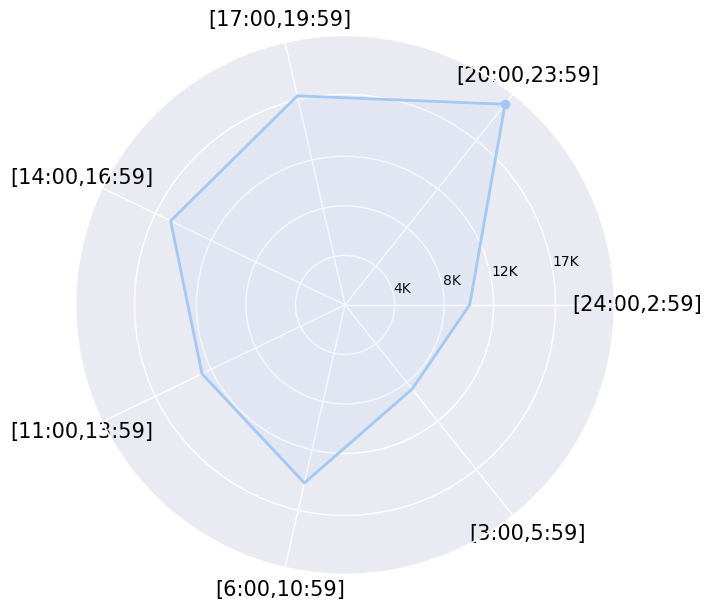

In [292]:
INTERVALS = [3,6,11,14,17,20,24]
plot_intervals(hours, INTERVALS)
;

In [11]:
del time
del hours

***

### 4. __[RQ4] In most cases, we will not have a consistent dataset, and the one we are dealing with is not an exception (ex. in the given datasets, you may not find the information of the profiles for some of the posts). So let’s enhance our analysis.__

***

####  Write a function that, given a profile_id, will be able to return the posts that belong to the given profile_id.

In [20]:
sub_posts = posts.col(['profile_id', 'post_id', 'numbr_likes', 'number_comments']) 

In [21]:
def post_finder(query, model=sub_posts):
    # the function will return a subset containing only the rows with profile_id equal to the query  
    return model[model["profile_id"] == query]

In [22]:
# let's try the function with an example profile_id
example = 5337907015
post_finder(example)

,post_id,profile_id,numbr_likes,number_comments
sid,,,,
28452667,BsRarTBBPmd,5337907015,30,6
28452668,BqOlb0kBQ5V,5337907015,25,5
28452669,BtxQHmLhI1h,5337907015,26,11
28452670,BxDLnoAhLJL,5337907015,24,3
28452671,BvFHZuWBcy2,5337907015,23,5
28452672,Bic19O-liDj,5337907015,28,0
28452673,BsTLZELBTnU,5337907015,28,0
28452674,BqTsJM_FDQ_,5337907015,28,0
28452675,ByB_OFnnGFM,5337907015,19,0


####  Write another function that, given an input n (an integer), will return the posts that belong to the n top posted profiles (top n profiles that have posted the highest number of posts) that their data is available in the profile.csv using the previously written function.

In [23]:
sub_profiles = profiles.col(['profile_id', 'n_posts'])

In [24]:
def top_posts_profiles(n):
    # find the n profiles who post the most using profiles dataset
    top_n_profiles = sub_profiles.nlargest(n, 'n_posts')
    # search and return all the posts that belongs to the top n profiles
    return sub_posts.loc[sub_posts['profile_id'].isin(top_n_profiles['profile_id']), 
                         ["profile_id", "post_id", "numbr_likes", "number_comments"]]

In [25]:
example = 3
top_posts_profiles(example)

,profile_id,post_id,numbr_likes,number_comments
sid,,,,
8768851,199664772,3V4OeXypTT,19,0
9253732,8563366588,BxJp4i3pArJ,0,0
9253733,8563366588,BxJp2qgpVJo,0,0
9253736,8563366588,BxJpzW4J6Aq,0,0
9253737,8563366588,BxJpxSLp4rB,0,0
...,...,...,...,...
39883139,1273455368,Bz6mAlXpyCK,3,0
39883141,1273455368,Bz6l-HkpF8G,2,0
39883143,1273455368,Bz6lo6RpKQF,2,0


####  What is the average number of "likes" and comments of the top 10 profiles with the highest number of posts which their information is available in profile.csv?

In [26]:
# through the previously created function it finds all the posts of the 10 users who post the most 
# with the associated number of likes and comments
top10 = top_posts_profiles(10)
# groups by profile_id and calculates the average of the number of likes their posts have got
round(top10[['profile_id', 'numbr_likes']].groupby('profile_id').mean(), 2)

,numbr_likes
profile_id,
9813508,0.3
199664772,7.67
218172998,0.4
285549744,3.92
1087613619,2.03
1273455368,2.96
1603889832,6.48
1607309412,1.54
8563366588,0.0


In [27]:
# groups by profile_id and calculates the average of the number of comments their posts have got
round(top10[['profile_id', 'number_comments']].groupby('profile_id').mean(), 2)

,number_comments
profile_id,
9813508,0.0
199664772,0.0
218172998,0.04
285549744,0.0
1087613619,0.18
1273455368,0.04
1603889832,0.04
1607309412,0.0
8563366588,0.0


In [28]:
del sub_posts, sub_profiles

####  Plot the number of posts that these top 10 profiles have sent on Instagram in the given interval in question RQ3. Interpret the resulting chart.

In [30]:
# create a new subset that contains only profile_id and cts
posts_cts = posts.col(['profile_id', 'cts'], index=False)
# keep only the rows in which a profile_id belonging to the top 10 appears
posts_cts =  posts_cts.loc[posts_cts["profile_id"].isin(top10['profile_id'])]
# add a column called hour in the same way of exercise 3
posts_cts['hour'] = posts_cts['cts'].map(lambda x: x.hour).astype('Int8')

In [136]:
prof_posts_hour = pd.DataFrame()
for user, post in posts_cts.groupby(by='profile_id'):
    # for each profile in top10 counts the intervals
    user_posts = plot_intervals(post['hour'].value_counts().sort_index().to_frame(), inters=INTERVALS, plot=False)
    user_posts['profile_id'] = user
    prof_posts_hour = prof_posts_hour.append(user_posts.reset_index())

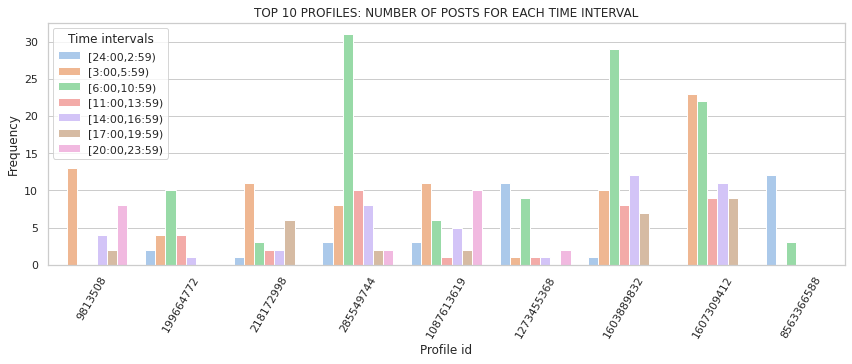

In [137]:
plt.figure(1, figsize=(12, 5))

ax = sns.barplot(data=prof_posts_hour, x="profile_id", y="count", hue="intervals", palette="pastel")
plt.xticks(rotation=60)
plt.tight_layout()
plt.title("TOP 10 PROFILES: NUMBER OF POSTS FOR EACH TIME INTERVAL")
plt.xlabel("Profile id")
plt.ylabel("Frequency")
h, l = ax.get_legend_handles_labels()
ax.legend(h, prof_posts_hour.intervals.unique(), title="Time intervals", loc='upper left')
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme(style="whitegrid")
plt.show()

Through the plot we can see how the users do not post equally in the different time intervals, in fact we notice how in each of them there are peaks corresponding to only one or at most two time bands. This was a reliable result that shows us a certain habits of people

In [ ]:
del posts_cts, prof_posts_hour, top10

***

### 5. __[RQ5] The most influential users are the ones with the highest number of “followers", you can now look more into their activity.__

***

####  Plot the top 10 most popular users in terms of followers and their number of posts.

In [18]:
# extract only the 10 users with the highest number of followers
top10 = profiles\
        .col(['profile_name', 'followers', 'n_posts'])\
        .dropna()\
        .nlargest(10, 'followers')

NameError: name 'top10' is not defined

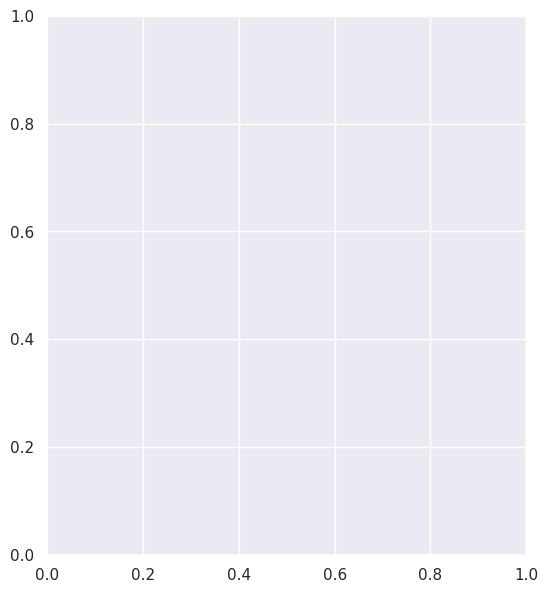

In [293]:
plt.figure(1, figsize=(21, 7))

color1 = sns.color_palette("pastel")[0]
color2 = sns.color_palette("pastel")[1]

plt.subplot(1, 3, 1)
g = sns.barplot(data=top10, x='followers', y='profile_name', color=color1)
plt.title("BARPLOT OF THE 10 USERS WITH MOST FOLLOWERS")
plt.ylabel("Profiles")
plt.xlabel("Number of followers")

plt.subplot(1, 3, 2)
g = sns.barplot(data=top10, x='n_posts', y='profile_name', color=color2)
plt.ylabel('')
plt.xlabel("Number of posts")
plt.title('Number of posts of the top 10 users')
g.set(yticklabels=[])  # remove the y-axis label

plt.subplot(1, 3, 3)
top10['norm_followers'] = top10['followers']/top10['followers'].max()
top10['norm_n_posts'] = top10['n_posts']/top10['n_posts'].max()

posts_bars = plt.barh(top10['profile_name'].iloc[::-1], top10['norm_n_posts'].iloc[::-1], 
         align='center', color=color2, tick_label=[''for i in top10['profile_name']])
followers_bars = plt.barh(top10['profile_name'].iloc[::-1], -top10['norm_followers'].iloc[::-1], 
         align='center', color=color1, tick_label=[''for i in top10['profile_name']])

plt.title('Number of followers vs posts of the top 10 users')
# plt.legend([followers_bars, posts_bars], ['Followers', 'Posts'], loc='lower right') 

plt.show()

####  Who is the most influential user?

In [20]:
top10[['profile_name']].head(1)

,profile_name
sid,
336492,instagram


The most influential user is the one with the most followers, so it's Instagram 

####  Have they posted anything with tagged locations? Extract the most frequent areas on their posts and plot the number of times each city has been visited.

In [21]:
# subset with only the needed columns of dataset posts
post_locations = posts.col(['sid_profile', 'location_id', 'post_type', 'numbr_likes', 'number_comments'])

In [22]:
# check for every influent user if they have tagged any location in a post
post_locations_influent = post_locations.loc[post_locations['sid_profile'].isin(top10.index), 
                                             ['sid_profile', 'location_id']]
print(top10.index.isin(post_locations_influent['sid_profile']))

[ True  True  True  True  True  True  True  True  True  True]


All of them has at least one post with a tagged location

In [23]:
# subset with only the needed columns of dataset locations
locations_city = locations.col(['id', 'city'], index=False)

In [24]:
# to find the cities most visited (it will takes the first ten)
top_city = locations_city.loc[locations_city['id'].isin(post_locations_influent['location_id'])].city.value_counts().head(10)
# we eliminate cities with empty name
top_city = top_city[top_city.index != '']

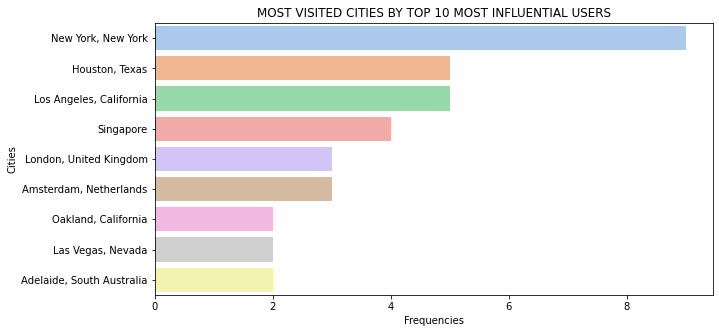

In [25]:
plt.figure(1, figsize=(10, 5))
sns.barplot(x=top_city, y=top_city.index, palette='pastel')
plt.xlabel('Frequencies')
plt.ylabel('Cities')
plt.title('MOST VISITED CITIES BY TOP 10 MOST INFLUENTIAL USERS')
plt.show()

####  How many pictures-only posts have they published? How many reels? (only videos) and how many with both contents? Provide the number as percentages and interpret those figures.

In [26]:
post_popular = post_locations[post_locations['sid_profile'].isin(top10.index)]
tab_type = pd.crosstab(post_popular['sid_profile'], post_popular['post_type'])
only_photos = tab_type[1].sum()
only_video = tab_type[2].sum()

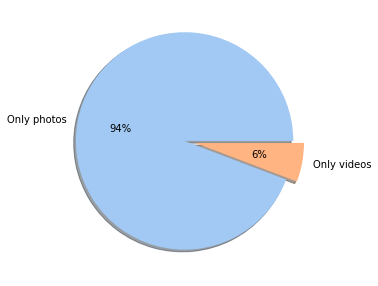

In [27]:
plt.figure(1, figsize=(25, 5))
colors = sns.color_palette('pastel')[0:3]
data = [only_photos, only_video]
explode = (0.1, 0)

labels=['Only photos', 'Only videos']
plt.pie(data, explode=explode, labels=labels, colors=colors, autopct='%.0f%%', shadow=True)
plt.show()

The most popular users have 0 post with both photos and videos. They tend to prefer posting only photos, infact the this percentage is very high, 94%, while only 6% of their posts contain video.

####  How many "likes" and "comments" did posts with only pictures receive? How about videos and mixed posts? Try to provide the average numbers and confront them with their followers amount, explaining what you can say from that comparison.

In [28]:
# subset with only popular users
posts_t_l_c = post_locations[post_locations['sid_profile'].isin(top10.index)]

On average a post with only photos gets more likes and more comments, so these type of post is the most engaging

In [29]:
# to calculate average number of likes and comment grouping by post types
round(posts_t_l_c.groupby(['post_type'])[['numbr_likes', 'number_comments']].mean(),2)

,numbr_likes,number_comments
post_type,,
1,414943.48,3098.18
2,266524.15,2019.85
3,<NA>,<NA>


Average number of likes and comments that each popular user receives on posts with photos

In [30]:
avg_tab_photos = round(posts_t_l_c[posts_t_l_c['post_type']==1].groupby(['sid_profile'])[['numbr_likes', 'number_comments']].mean().dropna(),2)
avg_tab_photos

,numbr_likes,number_comments
sid_profile,,
158690,86430.46,202.65
292359,99815.16,949.12
330376,82021.31,364.15
336492,888806.21,7597.21
337097,202911.48,1021.76
371414,213490.18,711.76
508140,863113.27,8594.73
3437294,473022.67,2237.08
3513205,1027101.85,6582.46


Average number of likes and comments that each popular user receives on posts with videos

In [31]:
avg_tab_videos = round(posts_t_l_c[posts_t_l_c['post_type']==2].groupby(['sid_profile'])[['numbr_likes', 'number_comments']].mean().dropna(),2)
avg_tab_videos

,numbr_likes,number_comments
sid_profile,,
336492,593409.67,5749.33
337097,207295.6,1026.8
371414,261408.0,583.0
3615154,41763.67,903.33


In [32]:
# At this point we merge the to subsets on "sid_profile"
profiles_followers = top10[['profile_name', 'followers']]
avg_tab_photos_foll = pd.merge(avg_tab_photos, profiles_followers, 
                               left_on=avg_tab_photos.index, right_on=profiles_followers.index)
avg_tab_photos_foll.rename(columns = {'key_0':'sid_profile'}, inplace = True)
avg_tab_photos_foll['post_type'] = 'Only photo'
avg_tab_photos_foll

,sid_profile,numbr_likes,number_comments,profile_name,followers,post_type
0,158690,86430.46,202.65,hm,29176804,Only photo
1,292359,99815.16,949.12,buzzfeedtasty,30246783,Only photo
2,330376,82021.31,364.15,louisvuitton,30689316,Only photo
3,336492,888806.21,7597.21,instagram,285457645,Only photo
4,337097,202911.48,1021.76,nba,35339708,Only photo
5,371414,213490.18,711.76,victoriassecret,65269440,Only photo
6,508140,863113.27,8594.73,danbilzerian,26476004,Only photo
7,3437294,473022.67,2237.08,andresiniesta8,29542143,Only photo
8,3513205,1027101.85,6582.46,akshaykumar,26252169,Only photo
9,3615154,141873.35,757.43,princessyahrini,29042823,Only photo


In [33]:
avg_tab_videos_foll = pd.merge(avg_tab_videos, profiles_followers, 
                               left_on=avg_tab_videos.index, right_on=profiles_followers.index)
avg_tab_videos_foll['post_type'] = 'Only video'
avg_tab_videos_foll.rename(columns = {'key_0':'sid_profile'}, inplace = True)
avg_tab_videos_foll

,sid_profile,numbr_likes,number_comments,profile_name,followers,post_type
0,336492,593409.67,5749.33,instagram,285457645,Only video
1,337097,207295.6,1026.8,nba,35339708,Only video
2,371414,261408.0,583.0,victoriassecret,65269440,Only video
3,3615154,41763.67,903.33,princessyahrini,29042823,Only video


In [34]:
avg_tab_foll = pd.concat([avg_tab_photos_foll, avg_tab_videos_foll], ignore_index=True)
avg_tab_foll['numbr_likes'] = avg_tab_foll['numbr_likes'].astype('int')
avg_tab_foll['number_comments'] = avg_tab_foll['number_comments'].astype('int')
avg_tab_foll['followers'] = avg_tab_foll['followers'].astype('int')
avg_tab_foll[['profile_name', 'followers', 'numbr_likes', 'number_comments', 'post_type']]

,profile_name,followers,numbr_likes,number_comments,post_type
0,hm,29176804,86430,202,Only photo
1,buzzfeedtasty,30246783,99815,949,Only photo
2,louisvuitton,30689316,82021,364,Only photo
3,instagram,285457645,888806,7597,Only photo
4,nba,35339708,202911,1021,Only photo
5,victoriassecret,65269440,213490,711,Only photo
6,danbilzerian,26476004,863113,8594,Only photo
7,andresiniesta8,29542143,473022,2237,Only photo
8,akshaykumar,26252169,1027101,6582,Only photo
9,princessyahrini,29042823,141873,757,Only photo


In [35]:
# we can calculate, on average, the proportions of likes/comments that a post type get
# with respect to the number of followers
avg1 = avg_tab_foll[avg_tab_foll['post_type']=='Only photo'].apply(lambda x: x.numbr_likes/x.followers, axis=1).mean()*100
avg2 = avg_tab_foll[avg_tab_foll['post_type']=='Only video'].apply(lambda x: x.numbr_likes/x.followers, axis=1).mean()*100
avg3 = avg_tab_foll[avg_tab_foll['post_type']=='Only photo'].apply(lambda x: x.number_comments/x.followers, axis=1).mean()*100
avg4 = avg_tab_foll[avg_tab_foll['post_type']=='Only video'].apply(lambda x: x.number_comments/x.followers, axis=1).mean()*100
[round(avg1, 4), round(avg2, 4), round(avg3, 4), round(avg4, 4)]
print(f'On average post with only photos has a percentage of likes, compared to the number of followers, equal to {round(avg1, 4)}%')
print(f'On average post with only videos has a percentage of likes, compared to the number of followers, equal to  {round(avg2, 4)}%')
print(f'On average post with only photos has a percentage of comments, compared to the number of followers, equal to  {round(avg3, 4)}%')
print(f'On average post with only videos has a percentage of comments, compared to the number of followers, equal to  {round(avg4, 4)}%')

On average post with only photos has a percentage of likes, compared to the number of followers, equal to 1.1368%
On average post with only videos has a percentage of likes, compared to the number of followers, equal to  0.3347%
On average post with only photos has a percentage of comments, compared to the number of followers, equal to  0.0079%
On average post with only videos has a percentage of comments, compared to the number of followers, equal to  0.0022%


We can conclude that on average the posts with only photos perform better than those with only videos, both in terms of the number of likes and in terms of the number of comments received. We note that in relation to the number of followers that a user has, the number of likes is usually much greater than the number of comments, even if the basic value is much smaller than the number of followers.

We can represent all this information in a scatterplot, but first it is usefull to apply a  log tranformation to the average number of likes and comments and to the number of followers in order to obtain a better representation.

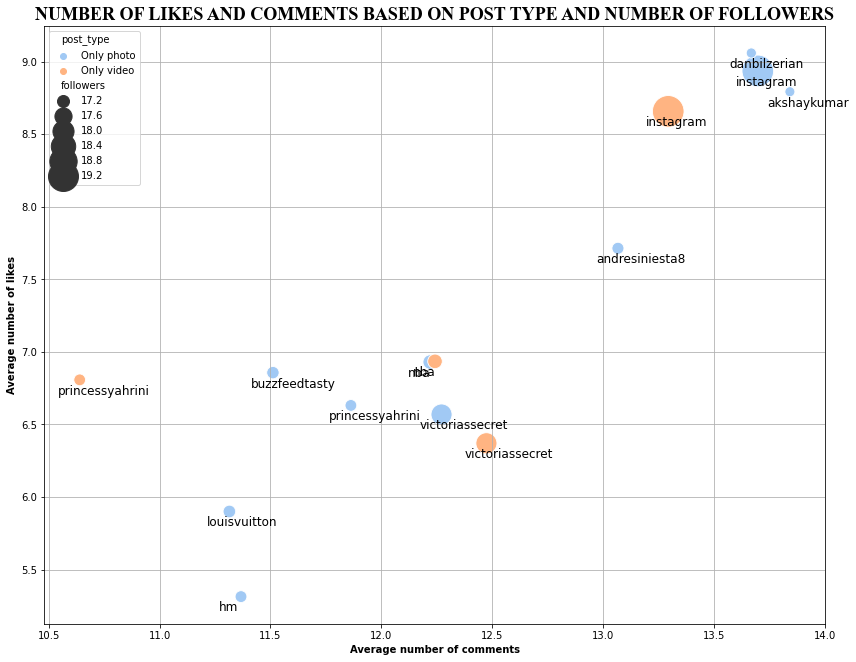

In [36]:
likes_log = avg_tab_foll['numbr_likes'].apply(lambda x: np.log(x+1))
comments_log = avg_tab_foll['number_comments'].apply(lambda x: np.log(x+1))
followers_log = avg_tab_foll['followers'].apply(lambda x: np.log(x+1))
post_type = avg_tab_foll['post_type']
#TODO log can be obtaimed with g.set(yscale=' log' )

plt.figure(1, figsize=(14, 11))
color1 = sns.color_palette("pastel")[0]
color2 = sns.color_palette("pastel")[1]
sns.scatterplot(x=likes_log, y=comments_log, hue=post_type, 
                size=followers_log, palette='pastel', sizes=(100,1000))
for i, name in enumerate (avg_tab_foll['profile_name']):
    plt.text(likes_log[i]-0.1, 
             comments_log[i]-0.1, name, fontsize=12)
plt.xlabel('Average number of comments',
          fontsize='10', color='black', fontweight="bold")
plt.ylabel('Average number of likes',
          fontsize='10', color='black', fontweight="bold")
plt.title('NUMBER OF LIKES AND COMMENTS BASED ON POST TYPE AND NUMBER OF FOLLOWERS',
          fontsize='18', color='black', fontweight="bold", fontname="Times New Roman")
plt.grid()
plt.show()

In [38]:
del top10, post_locations, post_locations_influent, locations_city

In [39]:
del top_city, post_popular, tab_type, posts_t_l_c, avg_tab_photos, avg_tab_videos, avg_tab_photos_foll

In [40]:
del avg_tab_videos_foll, avg_tab_foll

### 6. __[RQ6] It's time to get information from the user posting effectiveness.__

#### What is the average time (days and minutes) a user lets pass before publishing another post? Plot the top 3 users that publish posts more frequently (calculate the average time that passes between posts), including their amount of followers and following. Provide insights from that chart.

In [149]:
drift = lambda g: (g.max() - g.min()) / (g.count()-1) if g.shape[0] > 1 else pd.NA

post_time = posts\
                .col(['profile_id','sid_profile','cts'], index=None)\
                .groupby(by=['profile_id','sid_profile'], sort=False, dropna=True)\
                .aggregate(
                        drift=pd.NamedAgg(column="cts", aggfunc=drift),
                        count=pd.NamedAgg(column="cts", aggfunc="count"))\
                .dropna()
post_time = post_time[post_time.index.get_level_values('sid_profile') != -1]
post_time['drift'] = post_time['drift'].astype('timedelta64[ns]')
post_time.head()

,,drift,count
profile_id,sid_profile,,
1602360209,1817101,11 days 04:19:40.375000,25
448063035,3521482,0 days 00:43:03.400000,6
1945800451,3549421,426 days 11:16:52.500000,3
15802755,1891211,729 days 06:54:10,2
7020612328,4293767,399 days 01:16:39,2


We want to note that this kind of metric, as taken by itself alone, has **little or no value** since it doesn't take in account the number of posts, and it's not robust at all.

For example it could happen that people that have posted only a couple of times in a small interval of time are labeled as the most frequent post publishers.

In [150]:
N3 = 3 # 100
post_time = post_time[
    post_time.index.get_level_values('sid_profile') != -1
]
posters =  post_time\
            .droplevel('profile_id')
posters = posters[~posters.index.duplicated(keep='first')]

posters = pd.concat([
    posters,
    profiles.col(['followers', 'following'], index=True).dropna()
], axis=1, join='inner')
posters.nsmallest(3, columns='drift')

,drift,count,following,followers
3443921,0 days 00:00:22,2,146,167
2141500,0 days 00:00:26,2,1284,684
3256900,0 days 00:00:33,2,16,42


Here I plot on a graph the first 3 top frequency post publishers (excluding those that do not have a following/followers infos)

I honestly do not get any insight from this graph because:
- 3 isn't enough to get any useful insights
- this frequency measure we're taking in is not robust at all, and shouldn't be considered into account (for the aforementioned reasons)
- even when plotting much more points, the plot doesn't show any correlation between drift and the other two features
- some of the elements have $T = 0$, meaning that it may have happened that some posts have been posted in the exact same moment by the same account $frequency = \frac{1}{T} = \infty$

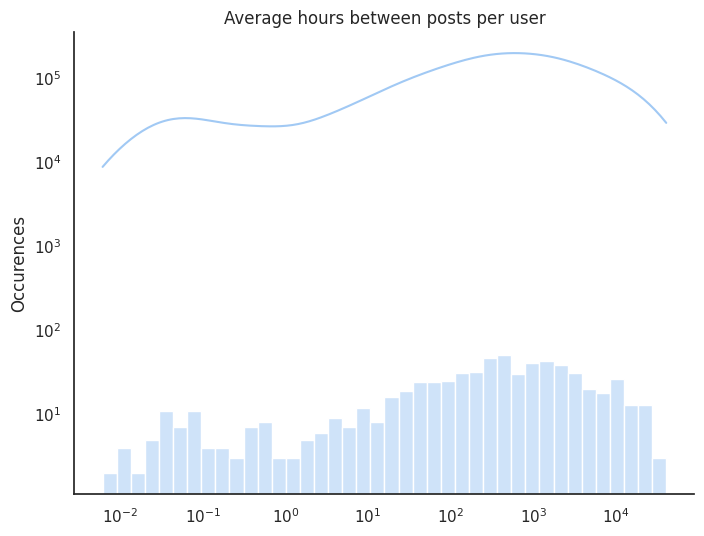

In [299]:
sns.set_style('white')
posters = posters[posters.drift > pd.Timedelta(seconds=1)]
ax = sns.histplot(
    x=posters.drift.dt.total_seconds()/3600,
    log_scale=True,
    bins=40,
    kde=True)
ax.set(
    title='Average hours between posts per user',
    xlabel='',
    yscale='log',
    ylabel='Occurences'
)
sns.despine()
plt.show()

We note that there are some users that tend to post very very often, as in fact we note a small bump when the x-axis is around $10^{-2} hours \sim 36s$. This denotes all those profiles that tend to post at an unhuman frequency, and may indicate errors in the dataset or that the profile is operated by a bot.

And now, the requested Mondrian painting:

,drift,count,following,followers
3443921,0 days 00:00:22,2,146,167
2141500,0 days 00:00:26,2,1284,684
3256900,0 days 00:00:33,2,16,42


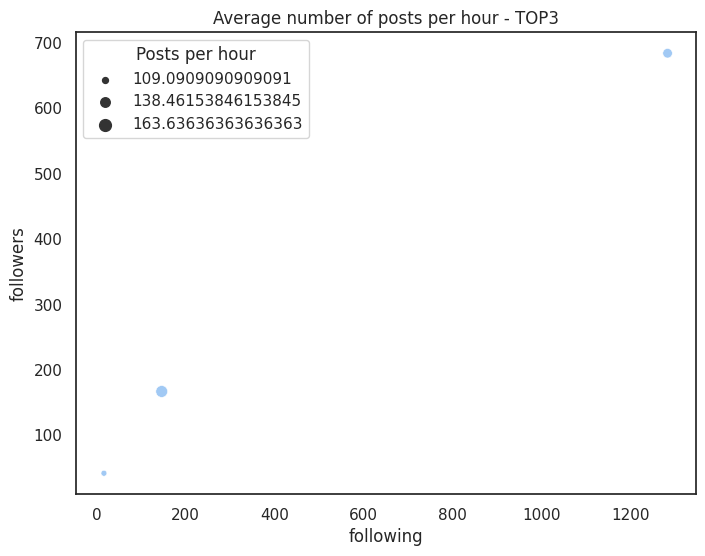

In [300]:
top3 = posters.nsmallest(3, columns='drift')
ax = sns.scatterplot(data=top3,
                x="following", 
                y="followers", 
                size=3600/top3['drift'].dt.total_seconds(), 
)
ax.legend(title='Posts per hour')
ax.set(
    title='Average number of posts per hour - TOP3',
)
display(top3)
plt.show()

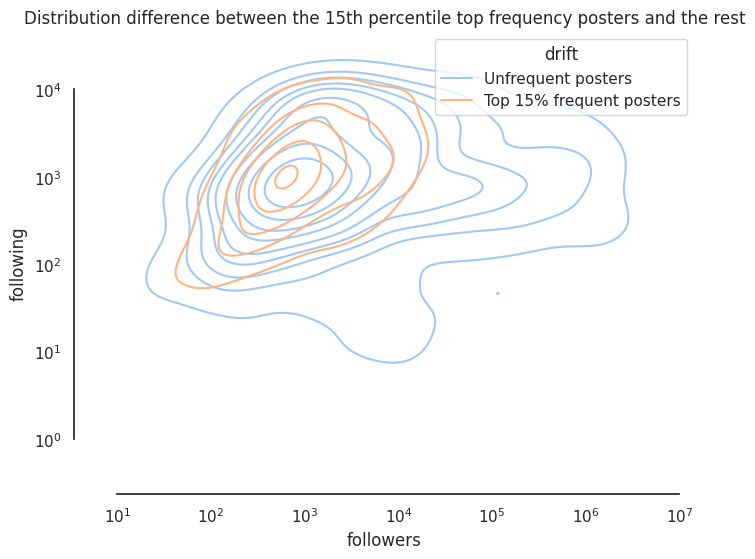

In [301]:
posters_density = posters[(posters.following > 0) & (posters.followers > 0)]

ax = sns.kdeplot(data=posters_density,
                x=posters_density['followers'].astype(int),
                hue=posters_density.drift.transform(lambda x: 'Top 15% frequent posters' if x<posters_density.drift.quantile(0.15) else 'Unfrequent posters'),
                y=posters_density['following'].astype(int),
                log_scale=True,
                palette="pastel",
                )
ax.set(
    title="Distribution difference between the 15th percentile top frequency posters and the rest",
)
sns.despine(trim=True)
plt.show()

We observe that the distribution of the Most frequent posters (MFQ) and the others are quite similar, and their peak values are even in the same area ($\sim
10^3 followers \times 10^3 following$). Nonetheless there are some notable differences:

- The non-MFQ is more skewed towards the bottom of the graph (users that follow less people) then the MFQ.
- The MFQ is way more skewed towards the right of the graph (users that have more followers)

This may be indicate that posting more frequently is in fact correlated with having more followers.

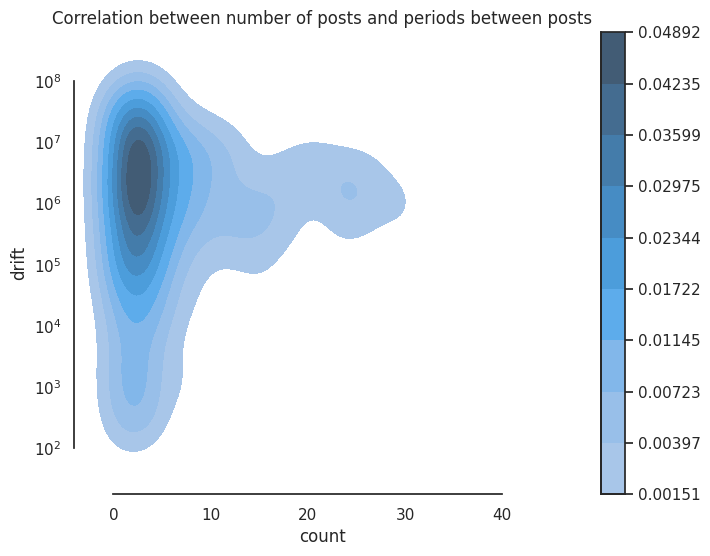

In [304]:
posters_no_outliers = posters[posters.drift.between(\
                                                   posters.drift.quantile(0.05),
                                                   posters.drift.quantile(0.95))]

ax = sns.kdeplot(data=posters_no_outliers,
                x="count" ,
                y=posters_no_outliers.drift.dt.total_seconds(), 
                fill=True,
                log_scale=(False,True),
                cbar=True)
ax.set(
    title="Correlation between number of posts and periods between posts",
)
sns.despine(trim=True)
plt.show()

This last graph tries to show why this metric isn't robust to outliers, when taken with no other information. As we can see this graph is heavily skewed towards the bottom-left, meaning that there's a lot of users that have a very low drift (high frequency), and only a few numbers of posts

In [ ]:
del post_time
del posters_no_outliers, posters_density, posters
sns.set_style('darkgrid')

#### Using the function you previously coded, plot the time intervals with the highest average number of “likes” and the ones with the highest average number of comments on posts.

In [ ]:
likes_time = posts.col(['numbr_likes', 'number_comments', 'cts'], index=False)
likes_time['hour'] = likes_time['cts'].dt.hour
likes_time.drop('cts', inplace=True, axis=1)

In [ ]:
plot_intervals(likes_time.groupby(by='hour').agg('mean'), INTERVALS, col_name='numbr_likes')

In [ ]:
plot_intervals(likes_time.groupby(by='hour').agg('mean'), INTERVALS, col_name='number_comments')

In [ ]:
del likes_time

### 7. __[RQ7] Of course, calculating probabilities is a job that any Data Scientist must know. So let's compute some engaging figures__

####  What's the probability that a post receives more than 20% "likes" of the number of followers a user has?

In [41]:
# First we create a subset of the posts dataframe that contains only the columns that we need
# and the rows for which we have a match (with the user) in the profiles dataset
sub_posts = posts.col(["sid_profile", "numbr_likes"])
sub_posts = sub_posts[sub_posts['sid_profile'] != -1]

In [42]:
# We create also a subset for the profiles dataset which contain only "sid" and "followers" 
# and the rows different from NA
sub_prof = profiles.col(["followers"]).dropna()

In [43]:
# At this point we merge the to subsets on "sid_profile"
merged_df = pd.merge(sub_posts, sub_prof, left_on="sid_profile", right_on=sub_prof.index)

In [44]:
# Then we can calculate the numbers of positive cases
pos_cases = merged_df[merged_df.numbr_likes > merged_df.followers*0.2].shape[0]
# And finally we calculate the probability dividing the positive cases for the total number of evaluated posts
print(f"Probability is equal to: {round(pos_cases/merged_df.shape[0]*100, 2)}%")

Probability is equal to: 15.24%


In [45]:
del sub_posts, sub_prof, merged_df, pos_cases

####  Do users usually return to locations? Extract the probability that a user returns to a site after having posted it in the past. Does that probability make sense to you? Explain why or why not.

In [46]:
# Subset that contains only the necessary columns of posts dataset
posts_loc = posts.col(["profile_id", "location_id"]).dropna()

In [47]:
# Then we eliminate the rows that do not contain duplicates in the values of the two columns
posts_loc2 = posts_loc[posts_loc.duplicated(subset=["profile_id", "location_id"], keep=False)]
# As a last step we eliminate the duplicates and take the value of the number of rows left
n_duplicates = posts_loc2.drop_duplicates(subset=["profile_id", "location_id"]).shape[0]
# We are now ready to calculate the probability...
# Considering as denominator the number of total different couple user-location:
prob_dupl = n_duplicates / posts_loc.groupby(["profile_id", "location_id"]).ngroups
print(f"Probability that a user returns to a site after having posted it in the past is equal to: {round(prob_dupl,4)*100}%")

Probability that a user returns to a site after having posted it in the past is equal to: 14.04%


This probability makes no sense for several reasons: 


$\bullet$ the first reason is that if a user tags a place in a post it does not mean that he has really been there


$\bullet$ even if a user tags a place twice, it may happen that the user tagged the location on the same day or maybe that in the future he/she publishes photos of the same place again without having returned there


$\bullet$ even if the user comes back two or more times to a location, he/she doesn't necessarily tag the location or make a post about it


$\bullet$ user can make a mistake in tagging the locations or maybe, even if a locations is the same, it can be tagged with slightly different names which does not result in a match

In [48]:
del posts_loc, posts_loc2, n_duplicates

### 8. __[RQ8] Every decision you take in a data-based environment should be reinforced with charts, statistical tests and analysis methods to check whether a hypothesis is correct or not.__

####  Does more “likes” also mean more comments? Plot a scatter plot of “likes” vs comments for posts.

In [49]:
# create a subset with only the necessaries columns of posts dataset
sub8_posts = posts.col(['profile_id', 'post_id', 'numbr_likes', 'number_comments', 'cts'], index=False).dropna()

In [36]:
# to check if there is a correlation between the number of likes and the number of comments
test_likes_vs_comments = pearsonr(sub8_posts['numbr_likes'], sub8_posts['number_comments'])
test_likes_vs_comments

(0.37445351725562276, 0.0)

Through the pearson correlation index we calculate the correlation between the two variables, we find that they are positively correlated. To test whether this correlation is statistically significant or not, we can calculate the p-value which, being <0.05, confirms that the correlation is statistically significant (p-value with dataset of this size has low reliability, so it has to be taken carefully)

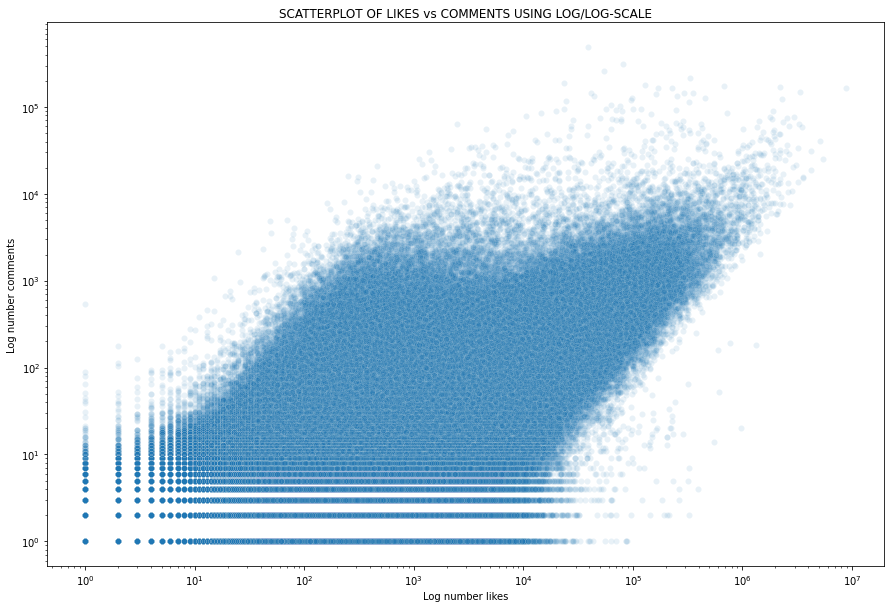

In [60]:
# To visualize the scatterplot it is useful to apply a logorithmic transformation both 
# to the values of the likes column and to the values of the comments column. 
# This transformation is used when the range of natural scales is too wide and there are 
# "extreme" values that make it impossible to display the graph correctly.
plt.figure(1, figsize=(15, 10))
scatter_plot = sns.scatterplot(data=sub8_posts, x="numbr_likes", y="number_comments", alpha=0.1)
scatter_plot.set(xscale="log", yscale="log")
plt.xlabel("Log number likes")
plt.ylabel("Log number comments")
plt.title("SCATTERPLOT OF LIKES vs COMMENTS USING LOG/LOG-SCALE")
plt.show()

####  Can you find any significant relationship between the time a user publishes a post and the number of comments and “likes”? Use an appropriate statistical test or technique and support your choice.

In [53]:
# first of all, using the functions of point 3, we create the columns concerning the time and the time interval
sub8_posts['hour'] = sub8_posts['cts'].map(lambda x: x.hour).astype('Int8')
sub8_posts['interval'] = sub8_posts['hour'].apply(lambda h: inter(h, [8,13,19,23]))

We can try the same approach as before and calculate the pearson correlation index, but this path is probably not the best since the hours in a day are not a continuous and increasing variable but a "cyclic" variable.


A solution could be to divide the bands of the day more significantly and consider it as a categorical variable, at this point it is possible to apply an anova test to check if the differences between the means of the groups are statistically significant or not. 

However, a further problem arises, in fact we need to divide by single user and do this test for each of them, as the Anova test also takes into account the variance of the groups which, containing enormous ranges of likes and comments, causes the test to be inaccurate.

| Time of day | Interval |
|---|---|
| Night | [23, 7:59] |
| Morning| [8, 12:29] |
| Afternoon | [13, 18:59] |
| Evening | [19, 22:59] |


In [10]:
test_likes = pearsonr(sub8_posts['hour'], sub8_posts['numbr_likes'])
test_comments = pearsonr(sub8_posts['hour'], sub8_posts['number_comments'])
print(f"Pearson correlation coefficient (r) between hour and likes: {round(test_likes[0],6)}")
print(f"Two-tailed p-value between hour and likes: {round(test_likes[1],6)}")
print(f"Pearson correlation coefficient (r) between hour and comments: {round(test_comments[0],6)}")
print(f"Two-tailed p-value between hour and comments: {round(test_comments[1],6)}")

Pearson correlation coefficient (r) between hour and likes: 0.001154
Two-tailed p-value between hour and likes: 0.0
Pearson correlation coefficient (r) between hour and comments: 0.000506
Two-tailed p-value between hour and comments: 0.000943


We get zero correlation but as mentioned the test may not be the most appropriate (the p-value for such large datasets is not reliable)

In [65]:
ciao = sub8_posts['profile_id'].value_counts().nlargest(10)
ciao

5421037289     599
12878122053    586
12413245305    570
13478139882    557
13324461711    538
12961349015    526
2243212181     450
5515448111     450
12606499712    395
4575459348     384
Name: profile_id, dtype: Int64

In [58]:
#Anova test with intervals column --- 5337907015
# voglio provare a calcolare per ogni profilo f_oneway e poi fare la media della f_statistic e del p_value
# oppure vedere la proporzione dele volte in cui il p-value è minore di 0.05
aaa = sub8_posts[sub8_posts['profile_id']==5337907015]
a = aaa['numbr_likes'][aaa['interval']=='[8:00,12:59]']
b = aaa['numbr_likes'][aaa['interval']=='[13:00,18:59]']
c = aaa['numbr_likes'][aaa['interval']=='[19:00,22:59]']
d = aaa['numbr_likes'][aaa['interval']=='[23:00,7:59]']
f_oneway(a, b, c, d)
#print(f'a={a}, b={b}, c={c}, d={d}') --- 1087612619

F_onewayResult(statistic=1.7394026610113864, pvalue=0.1835713280659018)

In [43]:
aaa

,post_id,profile_id,cts,numbr_likes,number_comments,hour,interval


In [43]:
sub8_posts['numbr_likes'][sub8_posts['interval']=='[19:00,22:59]']
sub8_posts['profile_id'].value_counts().nlargest(10)

0            80
2             9
7           198
10          114
11           16
           ... 
42710185     71
42710189    152
42710191    149
42710194     18
42710195     27
Name: numbr_likes, Length: 9577337, dtype: Int64

####  What’s the distribution of followers? Plot the empirical distribution of followers amongst all users and extract the mean, mode, and quantiles. Interpret those figures.

In [ ]:
# First we create a subset wich contains only the number of followers
profiles_followers = profiles.col(['followers'], index=False, nrows=SAMPLE_SIZE)
# Then we can drop all the NA because we don't need them to visualize the empirical distribution
profiles_followers.dropna(inplace=True)
# As a last step we apply the logaritm to the followers because the range is too big and otherwise would be impossible 
# to visualize them correctly. We use log(x+1) to avoid that profiles with 0 followers will result -inf
prof_foll_log = profiles_followers['followers'].apply(lambda x: np.log(x+1))

In [ ]:
sns.histplot(prof_foll_log, bins=100, kde=True)
plt.xlabel("Log(followers + 1)")
plt.ylabel("Frequency")
plt.title("HISTOGRAM OF THE FOLLOWERS DISTRIBUTION USING LOG-SCALE")
plt.show()

In [ ]:
# followers mean
followers_mean = round(np.mean(profiles_followers['followers']), 3)
print(f'Followers mean is equal to: {followers_mean}')
# followers mode
followers_mode = round(statistics.mode(profiles_followers['followers']), 3)
print(f'Followers mode is equal to: {followers_mode}')
# followers first quartile
followers_1stQuantile = int(np.quantile(profiles_followers['followers'], q=0.25))
print(f'Followers first quartile is equal to: {followers_1stQuantile}')
# followers median
followers_median = int(np.quantile(profiles_followers['followers'], q=0.5))
print(f'Followers median is equal to: {followers_median}')
# followers third quartile
followers_3rdQuantile = int(np.quantile(profiles_followers['followers'], q=0.75))
print(f'Followers third quartile is equal to: {followers_3rdQuantile}')

####  What are histograms, bar plots, scatterplots and pie charts used for?

Histograms, bar plots, scatterplots and pie charts are the most popular and used tools for data visualization.

* **Histograms** are used to represent continuous variables divided into a series of intervals. These intervals must be adjacent and they can be also of different sizes. They are also useful when dealing with large datasets because they can help in detecting any unusual observations (outliers) or any gaps in the data. Each bin (interval) is repreesented by a rectangle. If the bins have the same size, the height of the rectangle is proportional to the frequency (the number of cases in each interval), otherwise the *area* of the rectangle has to be proportional to the frequency. In this last case, the height represent the *frequency density* (the number of cases per unit of the variable on the x-axis). A histogram has an appearance similar to a vertical bar chart, but there are no gaps between the bars. Generally, a histogram will have bars of equal width. 

* **Bar plots** are used to compare categorical data with rectangular bars with heights or lengths proportional to the values that they represent. The bars can be plotted vertically or horizontally. A bar plot shows comparisons among discrete categories. One axis of the chart shows the specific categories being compared, and the other axis represents a measured value. They can also represent bars clustered in groups of more than one, showing the values of more than one measured variable.

* **Scatterplots** are a type of plot or mathematical diagram used to represent values for (usually) two variables in a Cartesian diagram. The data are displayed as a collection of points, each having the value of one variable determining the position on the horizontal axis and the value of the other variable determining the position on the vertical axis. With a scatterplot can be detected relations and correlations between variables. They can be used for both continuous and discrete variables.

* **Pie charts** are circular statistical graphics. The 'pie' is divided into slices proportional to the quantity they represent. They are suited to express percentage and to observe the composition of a phenomenon. The total sum of the percentages must be equal to 100%. If there are a lot of modalities related to the phenomenon we want to represent it can be worth to use a bar plot, because comparing the area of a lot of 'slices' can be not so easy.

####  What insights can you extract from a Box Plot?

**Box plots** provide a quick visual summary of the variability of values in a dataset. They help to identify the first quartile (as the lower box edge), the median (as the line inside the box) and the third quartile (as the upper box edge). In the box plots can be shown also lines representing the values located outside lower and upper quartiles. Outliers can reveal mistakes or unusual occurrences in data, and can be represented by single points. A box plot is created using a number or rate/ratio field on the y-axis.

In addition, it can be known the variability and the dispersion of the variable, looking at the length of the box. If the box is little, all the data is located near to the median, meaning that there's low dispersion; otherwise the result is a larger box. This type of plot can give also information about the symmetry of a variable. If the median line is in the center of the box, maybe the variable is symmetric (but is always needed to check it also with statistical parameters), otherwise the line will be closer to one box edge (quartile) than the other.

Box plots are useful to answer questions like: How is my data distributed? Are there any outliers in the dataset? 

| Component | Description |
|---|---|
| Whisker | The range of data less than the first quartile and greater than the third quartile. Each whisker has 25 percent of the data. Whiskers typically cannot be more than 1.5 times IQR, which sets the threshold for outliers. |
| Box | The range of data between the first and third quartiles. 50 percent of the data lies within this range. The range between the first and third quartile is also known as the Inter Quartile Range (IQR). |
| Maximum | The largest value in the dataset or the largest value that is not outside the threshold set by the whiskers. |
| Third quartile | The value where 75 percent of the data is less than the value, and 25 percent of the data is greater than the value. |
| Median | The middle number in the dataset. Half of the numbers are greater than the median and half are less than the median. The median can also be called the second quartile. |
| First quartile | The value where 25 percent of the data is less than the value, and 75 percent of the data is greater than the value. |
| Minimum| The smallest value in the dataset or the smallest value that is not outside the threshold set by the whiskers. |
| Outliers| Data values that are higher or lower than the limits set by the whiskers. |

***

## __Bonus points__

***

Up to this point, you probably have worked with one or two files simultaneously. Nevertheless, for the literals a. and b. of this section, you must work with the three datasets at the same time. Note that performing some of these operations might be too complex for your pc specs. For this reason, we suggest you make use of AWS (yeah! only a suggestion). In case you need it, in the following links you can find the same three files already mounted into AWS for you to work with them easily (instagram_posts, instagram_profiles, instagram_locations).

#### a. Sort the users in terms of number of followers and divide them into two groups: for the first group, take only the top 10% regarding "followers", and for the second one, take the rest. Now compare the mean of time intervals between posts for the two categories. Do you notice something relevant?

In [ ]:
profiles.df = profiles.col(['followers'], index=True).dropna()
profiles.df.head()

,followers
sid,
4184446,146
4184457,1145
4184460,324
4184465,192
4184471,4137


In [ ]:
drift = lambda g: (g.max() - g.min()) / (g.count()-1) if g.shape[0] > 1 else pd.NA

post_time = posts\
                .col(['sid_profile','cts'], index=None)\
                .groupby(by=['sid_profile'], sort=False, dropna=True)\
                .agg(drift=pd.NamedAgg(column="cts", aggfunc=drift))\
                .dropna()
post_time = post_time[post_time.index.get_level_values('sid_profile') != -1]
post_time['drift'] = post_time['drift'].astype('timedelta64[ns]')
post_time.head()

,drift
sid_profile,
3496776,17 days 10:03:56.027027
3303402,79 days 09:58:46.133333
3406435,2 days 02:45:14.545454
3529017,3 days 18:16:18.687500
3206132,124 days 00:16:34.333333


In [ ]:
profiles.df = pd.concat([
    post_time,
    profiles.df[['followers']]
], axis=1, join='inner')
profiles.df.head()

,drift,followers
1817101,5 days 14:09:50.187500,858
3521482,20 days 12:59:05.047619,5099
1891211,80 days 13:46:52.250000,559
4293767,22 days 22:59:48.409090,926
3414742,125 days 21:28:32.812500,4161


In [ ]:
profiles.df['category'] = pd.qcut(profiles.df.followers, [0.,0.9,1.], labels=['norm', 'influencer'])

print('Influencers mean time between posts: \t', profiles.df[profiles.df.category=='influencer'].drift.mean())
print('Normal users mean time between posts: \t', profiles.df[profiles.df.category=='norm'].drift.mean())

Influencers mean time between posts: 	 10 days 14:46:14.786765333

Normal users mean time between posts: 	 23 days 09:13:00.539863666


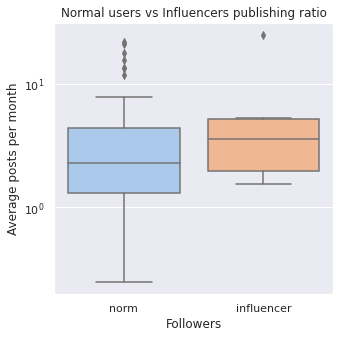

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})

ax = sns.boxplot(data=profiles.df, 
            x='category', 
            y=24*31*3600/profiles.df['drift'].dt.total_seconds(), 
            palette='pastel')
ax.set(
    xlabel = 'Followers',
    ylabel = 'Average posts per month',
    title = 'Normal users vs Influencers publishing ratio',
    yscale = 'log')
plt.show()

In [ ]:
del post_time
del profiles.df

#### b. Assume users publish their posts the same day pictures or videos are taken: Are there users that have visited the same location on the same day? How about the same week? Extract the results and explain them.

In [ ]:
posts.df = posts\
    .col(['location_id', 'profile_id', 'cts'])\
    .dropna()

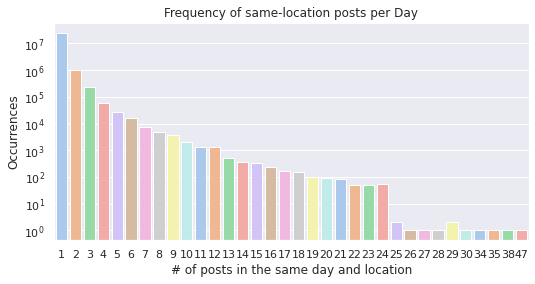

In [ ]:
day = posts.df\
            .groupby([pd.Grouper(key="cts", freq="1d"), 'location_id', 'profile_id'], sort=False)\
            .agg(cnt=pd.NamedAgg(column="cts", aggfunc='count'))['cnt']\
            .value_counts().sort_index()
sns.set(rc={'figure.figsize':(day.index.shape[0]/4,4)})
ax = sns.barplot(x=day.index, y=day, palette='pastel')
ax.set(
    xlabel = '# of posts in the same day and location',
    ylabel = 'Occurrences',
    title = 'Frequency of same-location posts per Day',
    yscale = 'log'
)
plt.show()

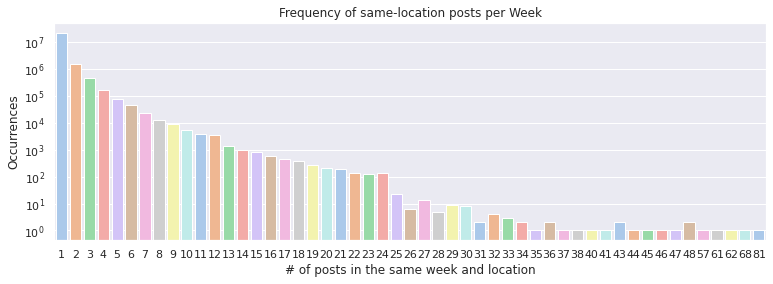

In [ ]:
week = posts.df\
            .groupby([pd.Grouper(key="cts", freq="1W"), 'location_id', 'profile_id'], sort=False)\
            .agg(cnt=pd.NamedAgg(column="cts", aggfunc='count'))['cnt']\
            .value_counts().sort_index()
sns.set(rc={'figure.figsize':(week.index.shape[0]/4,4)})
ax = sns.barplot(x=week.index, y=week, palette='pastel')
ax.set(
    xlabel = '# of posts in the same week and location',
    ylabel = 'Occurrences',
    title = 'Frequency of same-location posts per Week',
    yscale = 'log'
)
plt.show()

In [ ]:
del posts.df

#### c. Implement a text data analysis (also known as text mining) of the field "description" from instagram_posts.csv for descriptions written in English. Use appropriate visualizations and statistics to highlight the words (and probably the topics) provided for the users in that field.

The `langdetect` package uses a pretrained machine learning algorithm that supports 55 languages. Given any string it returns the closest match (if possible).

In [ ]:
%pip install langdetect
from langdetect import detect

detect('Questa libreria identifica la lingua usata!')




Note: you may need to restart the kernel to use updated packages.


'it'

Some of the strings may be too short for recognition, so we discard them. Also some strings may be composed of emojis only or mostly and those will give an error when passed to the `detect` function, so we enclose it in a `try-catch` statement.

In [ ]:
lang_share = pd.Series(dtype='Int32')
word_frequency = pd.Series(dtype='Int64')

for chunk in posts.col(
                ['description'], 
                index=False, 
                pandas=True, 
                chunksize=100000, 
                nrows=1000000):
    chunk.dropna(inplace=True)
    # Remove emojis and newlines     
    chunk.description = chunk.description.str.replace(EMOJIS, '', regex=True).replace(r'\\n', '', regex=True) 
    chunk = chunk[chunk.description.str.len() > 6]

    lang_chunk = chunk.description.apply(safe_detect)
    lang_share = lang_share.add(lang_chunk.value_counts(), fill_value=0)
    
    english_descr = chunk.description[lang_chunk == 'en']\
                        .str.extractall(r' (\w+)')\
                        .reset_index(drop=True)\
                        .value_counts()
    english_descr.index = english_descr.index.get_level_values(0)
    word_frequency = word_frequency.add(english_descr, fill_value=0)

In [ ]:
lang_share.sort_values(ascending=False, inplace=True)
lang_share.head()

en    471.0
ru    111.0
es     66.0
id     33.0
it     31.0
dtype: Float64

Most common languages:

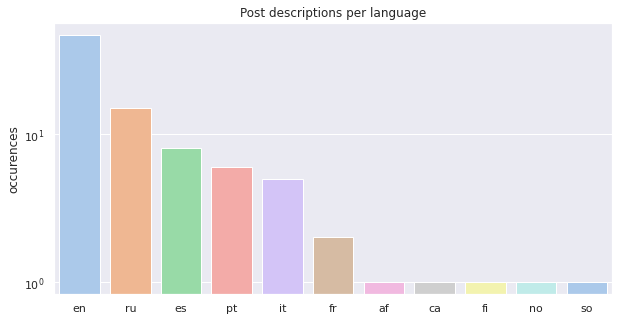

In [ ]:
g = sns.barplot(
    x=lang_share.index,
    y=lang_share,
    palette='pastel')
sns.set(rc={'figure.figsize':(.6*lang_share.count(),7)})
g.set(
    title='Post descriptions per language',
    yscale='log',
    ylabel='occurences'
)
plt.show()

`WordCloud` is a graphic library that helps you plot the most prominent words in a text to a Tag Cloud graph. After filtering out some of the words as Stopwords and selecting only the columns in english language, we are able to plot the most used words in english descriptions. 

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import string
STOPWORDS = set(STOPWORDS)
STOPWORDS.update({c for c in string.printable})
STOPWORDS.update({'ve', 'll', 're'})

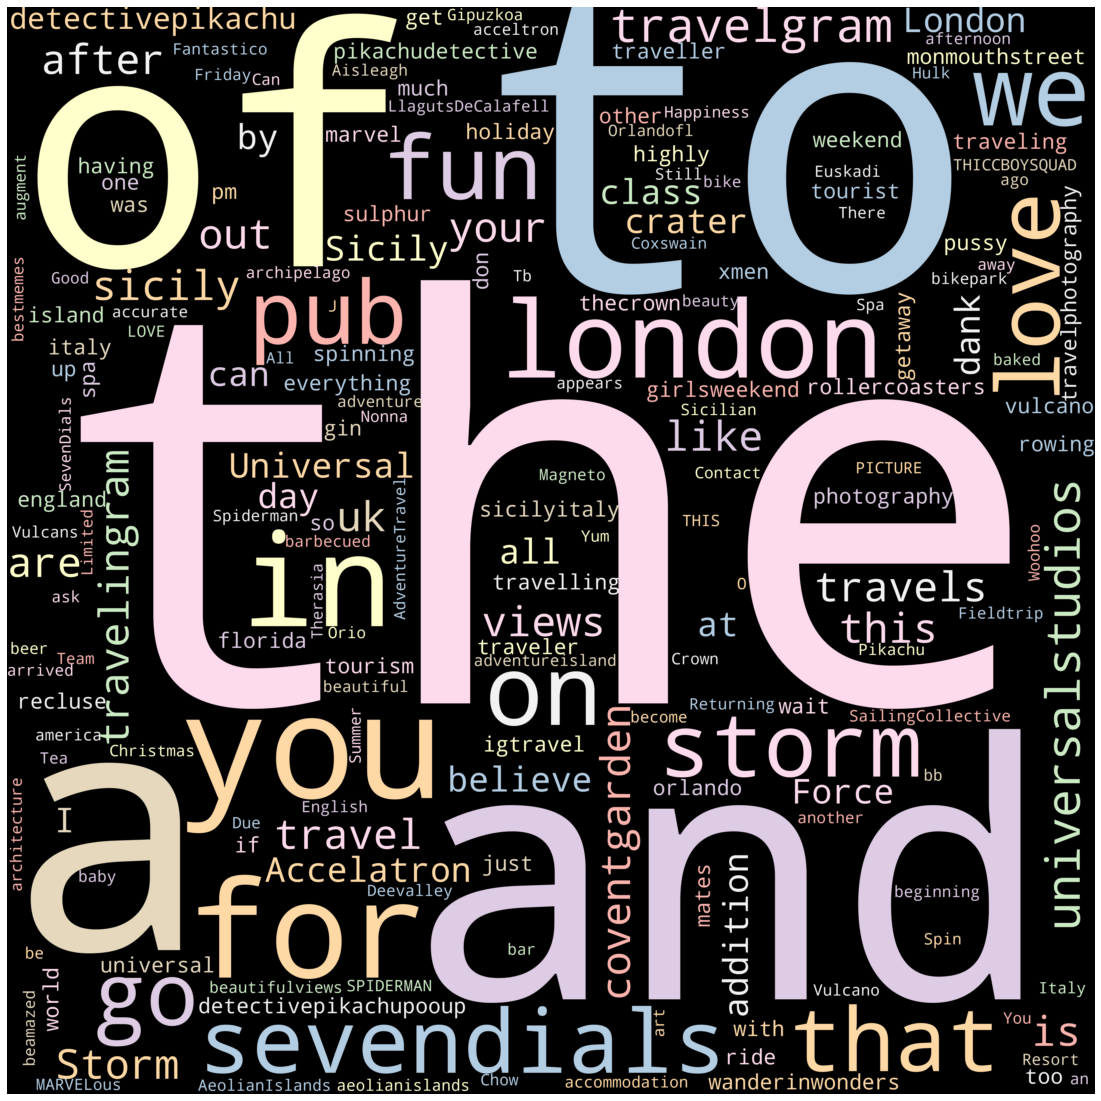

In [ ]:
word_dict = word_frequency.to_dict()
for stopword in STOPWORDS:
    # remove stopwords
    word_dict.pop(stopword, None)
    word_dict.pop(stopword.capitalize(), None)
    
wordcloud = WordCloud(
    width=1500, 
    height=1500, 
    margin=0, 
    background_color='white', 
    colormap='twilight',
    scale=4
).generate_from_frequencies(word_dict)

plt.figure( figsize=(15,15) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In order to analyze the results I would split it in some groups:
- Day : `day, today, now` : Many words refer to the current day meaning that this descriptions might have been used to refer and talk about the present events. This might point to a usage of descriptions (and Instagram) to talk and express feelings, as a way to interact with the world.
- Positives : `love, friend, thank, happy, life, beautiful` : There are many words that refer to the 'positive-thinking' sphere, meaning that users tend to post mainly positive moments about themselves and their surroundings. This may confirm the known trend of users being biased towards showing out only the best about their lives, trend that may contribute to the increasing problem of mental health and wellbeing, as many instagram users often associate it with high levels of anxiety, depression, bullying, unreachable body and living standards [$^1$](https://www.rsph.org.uk/about-us/news/instagram-ranked-worst-for-young-people-s-mental-health.html).

In [ ]:
del descr
del english_descr

***

## __Command Line Question__

***

Using the command line is a feature that Data Scientists must master. It is relevant since the operations there require less memory to use in comparison to other interfaces. It also does not use as much CPU processing time as other interfaces. In addition, it can be faster and more efficient and handle repetitive tasks quickly.

####  Using the instagram_posts.csv, retrieve the first ten posts with descriptions longer than 100 characters and output the profiles that posted them. (Please keep in mind that the profile associated with some of those posts may not be found in the profiles. You can simply output User was not found! for those posts.)

We start by taking the first 10 IDs of the descriptions longer than 100 characters
each of the following steps will pipe its result into the next one:

1. cat reads the content of the file
2. cut takes only the 2nd and 8th column of the file (sid_profile, description)
3. grep selects only the columns with longer descriptions than 100
4. head takes only the first 10 results
5. cut takes only the first column (sid_profile)
    
Then we iterate through the found IDs:

- if the ID is -1: 
    - then there is no corresponding user, we print "User was not Found"
- else:
    1. cat reads the content of the profiles file
    2. cut takes only 1st and 3rd column (sid, username)
    3. grep selects only the line where there is the searched ID
    4. cat prints out the result

```bash
#!/bin/bash
ids=$(cat instagram_posts.csv| cut --fields=2,8 -s | grep -oE '^-?[[:digit:]]+[[:blank:]]+.{100,}$' | head -10 | cut -f1)

while IFS= read -r id; do
	if [ "$id" = -1 ]; then
		echo User was not Found
	else
		cat instagram_profiles.csv | cut -f 1,3 | grep -w "$id" | cat
	fi
done <<< "$ids"
```

***

## __Algorithmic Question__

***

### 1. __[AQ1] Given the following pseudocode, answer the questions:__

```
Input:
       N : an integer
       List : array of characters of length N

function f1(sequence, end):
    For i=0 To end:
        OUTPUT sequence[i]
    EndFor
        Output "\n"

function f2(sequence, start, end):
    If start = end:
        f1(sequence, end)
    Else
        For i=start To end:
            temp <-- sequence[start]
            sequence[start] <-- sequence[i]
            sequence[i] <-- temp
            f2(sequence, start+1, end)
            temp <-- sequence[start]
            sequence[start] <-- sequence[i]
            sequence[i] <-- temp

f2(List, 0, N)
```

####  What is the output of this algorithm? Describe the mechanism of the algorithm in detail . We do not want to know only its final result. (Describe one example on your own)

This algorithm performs consecutives swaps of items in the array in order to obtain and print all the possible permutations of the initial array of characters.
At each call of $f_2$, starting from a certain parameter $i_{start}=0$, the function iterates in the set $\{i | i_{start} \leq i \leq N, i \in \N\}$ of $i$, each time swapping the char in position $i_{start}$ with the one in $i$, and then calling itself with parameter $i_{start}' = i_{start} + 1$. After this new call of $f2$ has ended, it swaps back $i_{start}$ and $i$, and proceeds to repeat the process for the next $i$. 

When $i_{start} = N$ the function prints the current state of the char array, through the $f1$ function.

The result is that all the possible permutations are printed, and the char array is left ordered at the end.

```
0:0	 a<>a	 ['a', 'p', 'e']
1:1	 p<>p	 ['a', 'p', 'e']
2:2	 e<>e	 ['a', 'p', 'e']
OUTPUT	ape
2:2	 e<>e	 ['a', 'p', 'e']
1:1	 p<>p	 ['a', 'p', 'e']
1:2	 p<>e	 ['a', 'p', 'e']
2:2	 p<>p	 ['a', 'e', 'p']
OUTPUT	aep
2:2	 p<>p	 ['a', 'e', 'p']
1:2	 e<>p	 ['a', 'e', 'p']
0:0	 a<>a	 ['a', 'p', 'e']
0:1	 a<>p	 ['a', 'p', 'e']
1:1	 a<>a	 ['p', 'a', 'e']
2:2	 e<>e	 ['p', 'a', 'e']
OUTPUT	pae
...
```



####  What is asymptotically (i.e., we are asking for big-O complexity) the algorithm's running time as a function of N?

Let $n = N - i_{start}$, then at any call of $f_2(N-n)$ it performs $2n$ swaps, calling $n$ times $f_2(N-n-1)$. So each function call calls another function $n$ times:
$$
    T(n) = 
    \begin{cases} 
        N & n = 0 \\
        n \cdot T(n-1) + O(1) & n>0
    \end{cases} 
$$
$$
    T(N) = O(1) + N(N-1)(N-2)...2\cdot 1 \cdot N = O(N \cdot N!)
$$

####  Is this algorithm the optimal one to produce this output? If not, can you suggest a better algorithm to perform the same task?

**Space complexity**: at any given time the only memory consumed is the one by the array and 2 variables, so the space complexity is linear $O(N)$, hence optimal.

**Time complexity**: the problem with this kind of task is the hugeness of the required output. In fact the number of permutations of any given string is $N!$, and only by printing the output we would have to print at least $N!$ times a string of length $N$, as such it can be easily observed that this problem is $\Omega(N\cdot N!)$. Since our solution is in time $O(N\cdot N!)$ we can say that our algorithm is **asymptotically optimal**.

One might try optimizing function calls, e.g. transforming this function in a non recursive one, but no substantial improvement will be obtained.

### 3. __[AQ2] Considering the following problem, answer the questions:__

#### Alex has a ribbon of length N. He wants to cut the ribbon in a way that fulfils the following __three__ conditions:
- Each piece of the cut should have an integer length
- He should at least cut the ribbon once
- The __multiplication__ of the length of all the pieces be the maximum possible

#### 1. Implement a __recursive algorithm__ to help Alex find the maximum possible value after multiplying the length of the pieces. Explain your algorithm in detail.

In [ ]:
def ribbon_cut_exp(N):
    if N == 1:
        return 1
    M = 0
    for i in range(1,N//2+1):
        left_max = max(i, ribbon_cut_exp(i))
        right_max = max(N-i, ribbon_cut_exp(N-i))
        M = max(M, left_max * right_max)
    return M
                            
ribbon_cut_exp(12)

19683

At each function call $f(n)$ the algorithm iterates over the integer values of $i \in [1, \frac{N+1}{2}]$, and operates a "single cut" in $i$. When this is done it recursively calls $f(n-i)$ and $f(i)$ and after getting the result it compares, by using `max`, whether it's better to keep the that part of the ribbon uncutted, or better to cut it up into pieces. Finally it compares the result of the cut in that $i$ with those of the previous, and keeps only the best one (`max`).

The base step of this recursive function is when $f(n=1)$, in that case the result is always 1.

#### 2. Show that the algorithm has exponential running time.

When the function is called with a certain parameter $N$ the func calls $N-1$ other instances of itself with parameters $\{n | n \in [1,N-1]\}$. Each function has $O(n)$ complexity, since it has to compute $O(n)$ products and maximums.

So the number of executions is
$$
    T(n) = 
    \begin{cases}
        O(1) & n=1 \\
        O(n) + \sum_{i=0}^{n-1} T(i) & elsewhere
    \end{cases}
$$
$$
    T(N) = O(N) + T(N-1) + T(N-2) + ... + T(1) = O(N) + 2 \cdot T(N-1) = O(N + 2^N) = O(2^N)
$$

#### 3. Now provide a polynomial solution, based on __dynamic programming__, and compute its running-time complexity.

In [11]:
def ribbon_cut_poly(N):
    if N <= 2:
        return 1
    cuts = [1,2]
    for x in range(3,N+1):
        M = 0
        for i in range(1,x//2+1):
            left_max = max(i, cuts[i-1])
            right_max = max(x-i, cuts[x-i-1])
            M = max(M , left_max * right_max)
        cuts.append(M)
    return cuts[N-1]
    
ribbon_cut_poly(12)

81

At the $j^{th}$ iteration of the outer loop, the function iterates $j/2$ times in the inner loop. The inner loop computes each time some $O(1)$ operations.
At the end the total number of operations performed is:
$$
    T(N) = (1 + 2 + ... + (N-1) + N)/2 = \frac{N (N-1)}{4} = O(N^2)
$$

#### 4. Evaluate the running time of your algorithm for the sizes (Ns) in the __range of [2, 25]__, plot the results, and interpret it (if you have implemented two algorithms, please include both in the plot and compare them).

In [29]:
from timeit import timeit

performance = {
    'time' : [],
    'type' : [],
    'N' : []
}
N_RANGE = 15 # 26, but 13 is more than enough
for i in range(2,N_RANGE):
    performance['time'].append(timeit(lambda: ribbon_cut_poly(i), number = 1000) * 10**6)
    performance['type'].append('poly')
    performance['N'].append(i)
    
    performance['N'].append(i)
    performance['time'].append(timeit(lambda: ribbon_cut_exp(i), number=1000) * 10**6)
    performance['type'].append('exp')

[Text(0, 0.5, 'time [s]'), Text(0.5, 1.0, 'Exponential vs Polynomial')]

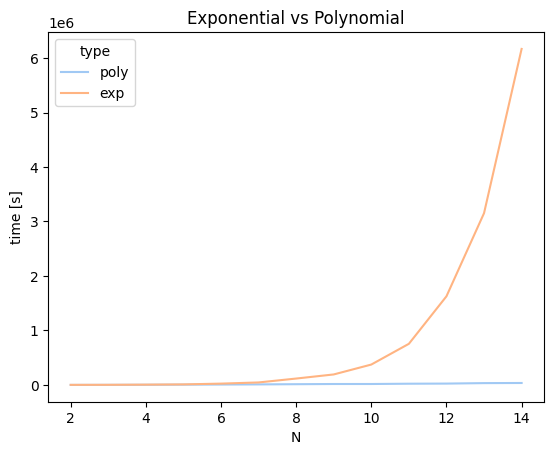

In [30]:
cut_performance = pd.DataFrame.from_dict(performance)
g = sns.lineplot(data=cut_performance,x='N', y='time', hue='type', palette='pastel')
g.set(ylabel='time [s]', title="Exponential vs Polynomial")

#### 5. (Optional, mini bonus) Is the algorithm of question 3 __optimal__? If you belive it, can you prove it? If not, can you find a faster algorithm? In case you found a faster algorithm implement it and explain your algorithm in detail.

The algorithm is not optimal, because the answer can be easily computed by a constant function with complexity $O(1)$

$
f(x) = 
\begin{cases} 
          x & 0 < x \leq 2 \\
          3^{\frac{x}{3}} & x \mod{3} = 0 \\
          2^2 \cdot 3^{\frac{(x-4)}{3}} & x \mod{3} = 1\\
          2 \cdot 3^{\frac{x-2}{3}} & x \mod{3} = 2
       \end{cases}
$


In [31]:
def ribbon_cut_const(N):
    if N <= 3:
        return N
    if N % 3 == 0:
        return 3** (N // 3)
    if N % 3 == 1:
        return 4 * 3** ((N-4)//3)
    if N % 3 == 2:
        return 3**(N//3) * 2
    
ribbon_cut_const(12)

81

[Text(0, 0.5, 'time [s] : logscale'),
 Text(0.5, 1.0, 'Exponential vs Polynomial vs Constant'),
 None]

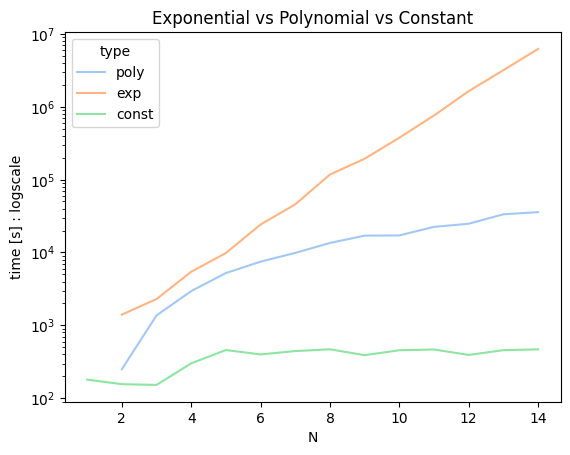

In [32]:
for i in range(1,N_RANGE):
    performance['N'].append(i)
    performance['time'].append(timeit(lambda: ribbon_cut_const(i), number=1000))
    performance['type'].append('const')
    
cut_performance = pd.DataFrame.from_dict(performance)
g = sns.lineplot(data=cut_performance,x='N', y='time', hue='type', palette='pastel')
g.set(ylabel='time [s] : logscale', title="Exponential vs Polynomial vs Constant", yscale='log')